In [1]:
import uproot
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
import os
from collections import Counter

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from scipy.interpolate import UnivariateSpline
import umap
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import hdbscan

c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "/Users/edwar/OneDrive/Documents/Documents/2025/RS_2015_MagDown_No_Offline_reduced.root" #Smaller RS
tree_name = "DecayTree"

with uproot.open(file_path) as file:
    tree = file[tree_name]
    #variables = ["Dst_pi_TRACK_GhostProb", "verified_id_D0_Part_OS_Pi_1_ProbNNpi"]
    variables = ["D0_IPCHI2_OWNPV", "cos_theta_pis_trig"
             , "Dst_pi_ProbNNpi_common", "D0_Loki_DOCAMAX", "Dst_pi_IPCHI2_OWNPV"
             , "Dst_pi_PT", "D0_Loki_VCHI2NDOF", "Dst_pi_TRACK_CHI2NDOF"
             , "Dst_pi_TRACK_GhostProb", "verified_id_D0_Part_OS_Pi_1_ProbNNpi"]

    data = tree.arrays(variables, library="pd")
    D0_M_data = tree["Dst_ReFit_D0_M_best"].array(library="pd")
    deltam_ReFit_data = tree["deltam_ReFit"].array(library="pd")

data['D0_IPCHI2_OWNPV'] = np.log(data['D0_IPCHI2_OWNPV'])
data['Dst_pi_ProbNNpi_common'] = np.log(data['Dst_pi_ProbNNpi_common'])
data['Dst_pi_IPCHI2_OWNPV'] = np.log(data['Dst_pi_IPCHI2_OWNPV'])
data['Dst_pi_TRACK_GhostProb'] = np.log(data['Dst_pi_TRACK_GhostProb'])

In [3]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[variables])
#scaled_data_ws = scaler.fit_transform(data_ws[variables_ws])
sampled_data = pd.DataFrame(scaled_data).sample(frac=1, random_state=1)
print(scaled_data.shape)
#print(scaled_data_ws.shape)
print(sampled_data.shape)

(50000, 10)
(50000, 10)


In [4]:
n_neighbours_values = [3, 5 ,10, 15, 20, 50, 100, 200, 500, 1000, 2000, 5000]

# Directory to save plots and pickle file
save_dir = r"C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_unclustered"
os.makedirs(save_dir, exist_ok=True)
# File path for the pickle file
umap_pickle_path = os.path.join(save_dir, "umap_embeddings.pkl")

# Load existing UMAP results if the pickle file exists
if os.path.exists(umap_pickle_path):
    with open(umap_pickle_path, 'rb') as f:
        umap_results = pickle.load(f)
    print(f"Loaded existing UMAP embeddings from {umap_pickle_path}")
else:
    umap_results = {}  # Initialize if no file exists
    print(f"No existing UMAP embeddings found. Starting fresh.")

# List to store metadata for each plot
plot_metadata = []

# Perform UMAP dimensionality reduction and save results
for n_neighbours in n_neighbours_values:
    print(f"Running UMAP for n_neighbours={n_neighbours}...")
    try:
        # Perform UMAP embedding
        umap_reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbours, random_state=42)
        umap_embedding = umap_reducer.fit_transform(sampled_data)

        # Update UMAP results (overwrite if exists)
        umap_results[n_neighbours] = umap_embedding

        # Create and save individual plot
        plt.figure(figsize=(8, 6))
        plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=5, alpha=0.6)
        plt.title(f"UMAP (n_neighbours={n_neighbours})")
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        
        # Save plot
        plot_file_name = f"UMAP_unclustered_n_neighbours_{n_neighbours}.png"
        plot_path = os.path.join(save_dir, plot_file_name)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        # Add metadata for this plot
        plot_metadata.append({
            'n_neighbors': n_neighbours,
            'file_name': plot_file_name,
            'file_path': plot_path,
            'description': f"UMAP plot with n_neighbors={n_neighbours}"
        })

        print(f"Saved plot and updated embedding for n_neighbours={n_neighbours}")

    except ValueError as e:
        print(f"Error processing n_neighbours={n_neighbours}: {e}")
        plot_metadata.append({
            'n_neighbors': n_neighbours,
            'file_name': None,
            'file_path': None,
            'description': f"Error: {e}"
        })

# Save updated UMAP results back to the pickle file
with open(umap_pickle_path, 'wb') as f:
    pickle.dump(umap_results, f)
print(f"Updated UMAP embeddings saved to {umap_pickle_path}")

# Save metadata to CSV
metadata_df = pd.DataFrame(plot_metadata)
metadata_csv_path = os.path.join(save_dir, "UMAP_plot_metadata.csv")
metadata_df.to_csv(metadata_csv_path, index=False)
print(f"Metadata saved to {metadata_csv_path}")


Loaded existing UMAP embeddings from C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_unclustered\umap_embeddings.pkl
Running UMAP for n_neighbours=3...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=3
Running UMAP for n_neighbours=5...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=5
Running UMAP for n_neighbours=10...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=10
Running UMAP for n_neighbours=15...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=15
Running UMAP for n_neighbours=20...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=20
Running UMAP for n_neighbours=50...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=50
Running UMAP for n_neighbours=100...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=100
Running UMAP for n_neighbours=200...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=200
Running UMAP for n_neighbours=500...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=500
Running UMAP for n_neighbours=1000...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=1000
Running UMAP for n_neighbours=2000...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=2000
Running UMAP for n_neighbours=5000...


c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved plot and updated embedding for n_neighbours=5000
Updated UMAP embeddings saved to C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_unclustered\umap_embeddings.pkl
Metadata saved to C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_unclustered\UMAP_plot_metadata.csv


Running t-SNE for perplexity=5...
Running t-SNE for perplexity=15...
Running t-SNE for perplexity=30...
Running t-SNE for perplexity=50...
Running t-SNE for perplexity=100...
Running t-SNE for perplexity=200...
Running t-SNE for perplexity=500...
Running t-SNE for perplexity=1000...
Metadata saved to C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_tSNE_unclustered\tSNE_plot_metadata.csv
Shared plot saved to C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_tSNE_unclustered\tSNE_combined_plot.png
UMAP embeddings saved to C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_tSNE_unclustered\tsne_embeddings.pkl


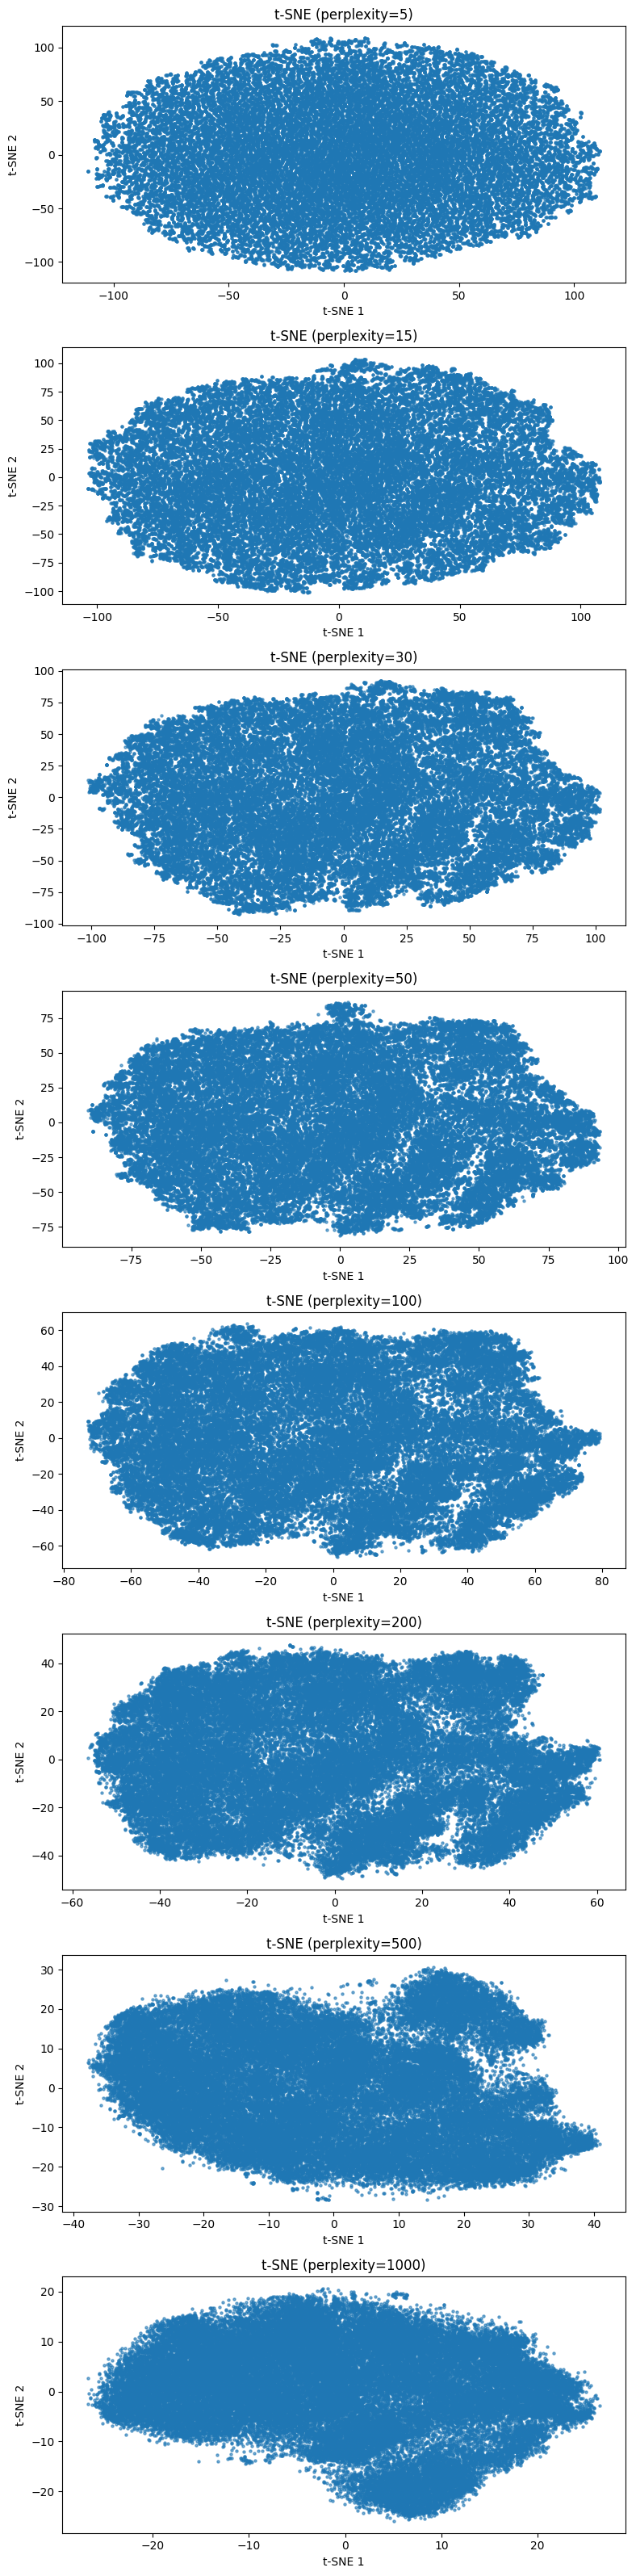

In [5]:
perplexity_values = [5, 15, 30, 50, 100, 200, 500, 1000]#[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
# Dictionary to store t-SNE embeddings
tsne_results = {}

# List to store metadata for each plot
plot_metadata = []

# Directory to save plots
save_dir = r"C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_tSNE_unclustered"
os.makedirs(save_dir, exist_ok=True)

# Shared figure for t-SNE plots
fig, axes = plt.subplots(len(perplexity_values), 1, figsize=(8, len(perplexity_values) * 4))

# Step 1: Perform t-SNE Dimensionality Reduction and Plot
for i, perplexity in enumerate(perplexity_values):
    ax = axes[i] if len(perplexity_values) > 1 else axes  # Handle single subplot edge case
    try:
        print(f"Running t-SNE for perplexity={perplexity}...")
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_embedding = tsne.fit_transform(sampled_data)
        tsne_results[perplexity] = tsne_embedding  # Store in dictionary
        
        # Create individual plot
        fig_individual, ax_individual = plt.subplots(figsize=(8, 6))
        ax_individual.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=5, alpha=0.6)
        ax_individual.set_title(f"t-SNE (perplexity={perplexity})")
        ax_individual.set_xlabel('t-SNE 1')
        ax_individual.set_ylabel('t-SNE 2')
        
        # Save plot with unique filename
        file_name = f"tSNE_unclustered_perplexity_{perplexity}.png"
        save_path = os.path.join(save_dir, file_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig_individual)
        
        # Store metadata
        plot_metadata.append({
            'perplexity': perplexity,
            'file_name': file_name,
            'file_path': save_path,
            'description': f"t-SNE plot with perplexity={perplexity}"
        })
        
        # Add to shared subplot
        ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=5, alpha=0.6)
        ax.set_title(f"t-SNE (perplexity={perplexity})")
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
    
    except ValueError as e:
        print(f"Error with perplexity={perplexity}: {e}")
        ax.axis('off')
        ax.set_title(f"perplexity={perplexity}\nError: {e}")
        plot_metadata.append({
            'perplexity': perplexity,
            'file_name': None,
            'file_path': None,
            'description': f"Error: {e}"
        })

# Step 2: Save Metadata to CSV
metadata_df = pd.DataFrame(plot_metadata)
metadata_csv_path = os.path.join(save_dir, "tSNE_plot_metadata.csv")
metadata_df.to_csv(metadata_csv_path, index=False)
print(f"Metadata saved to {metadata_csv_path}")

# Save the combined plot
shared_plot_path = os.path.join(save_dir, "tSNE_combined_plot.png")
plt.tight_layout()
plt.savefig(shared_plot_path, dpi=300, bbox_inches='tight')
print(f"Shared plot saved to {shared_plot_path}")

tsne_pickle_path = os.path.join(save_dir, "tsne_embeddings.pkl")

# Save t-SNE results to pickle
with open(tsne_pickle_path, 'wb') as f:
    pickle.dump(tsne_results, f)

print(f"UMAP embeddings saved to {tsne_pickle_path}")

# Display the shared plot
plt.show()

Plotting core distances for n_neighbours=3...


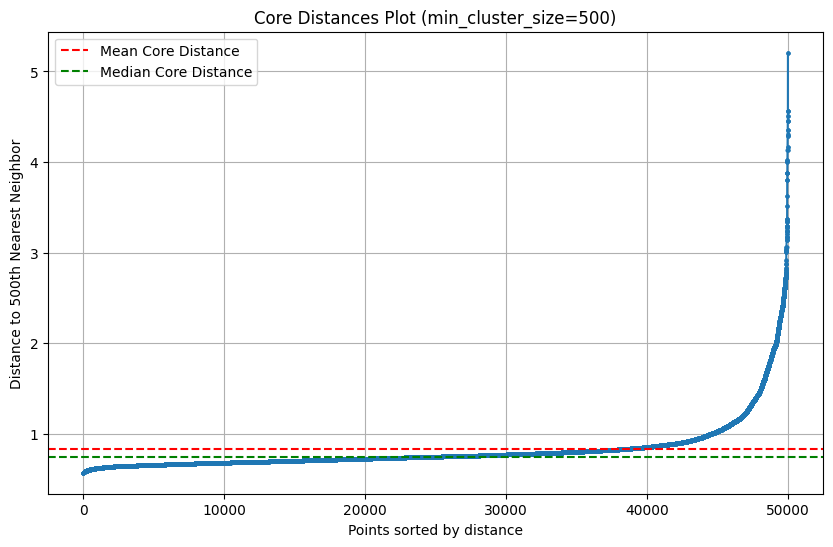

Plotting core distances for n_neighbours=5...


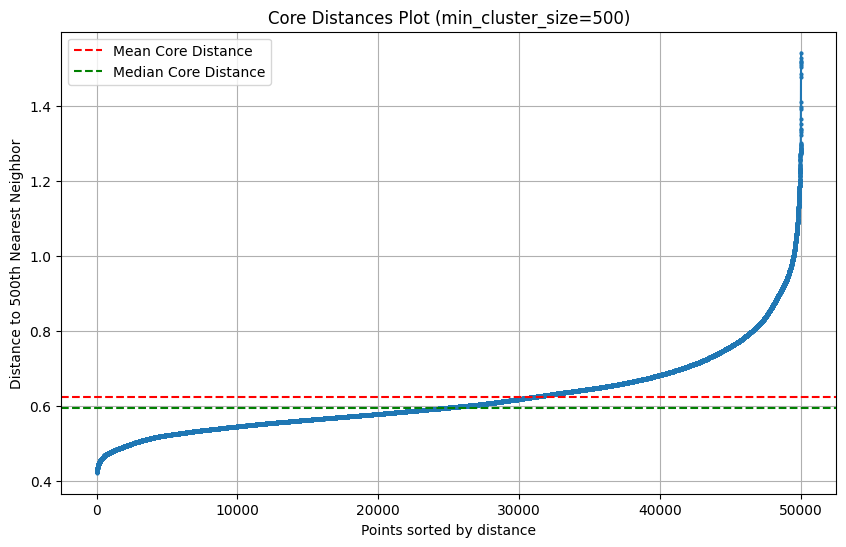

Plotting core distances for n_neighbours=10...


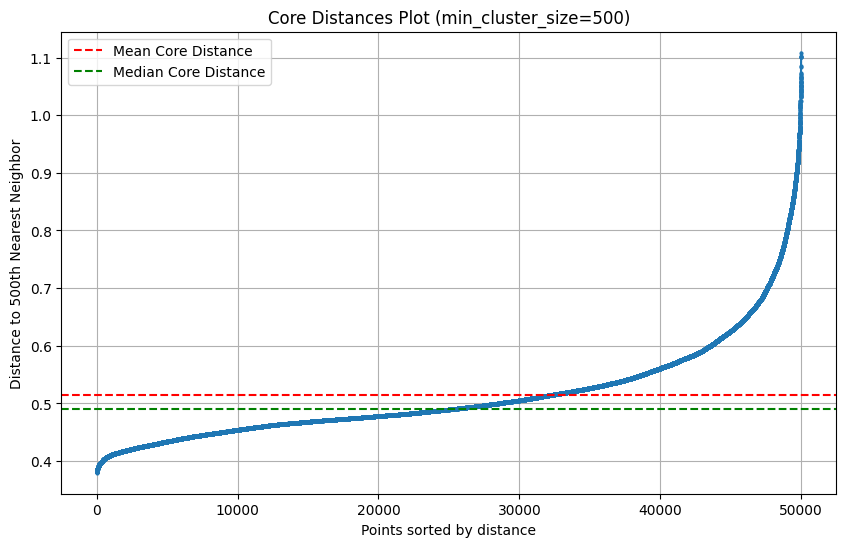

Plotting core distances for n_neighbours=15...


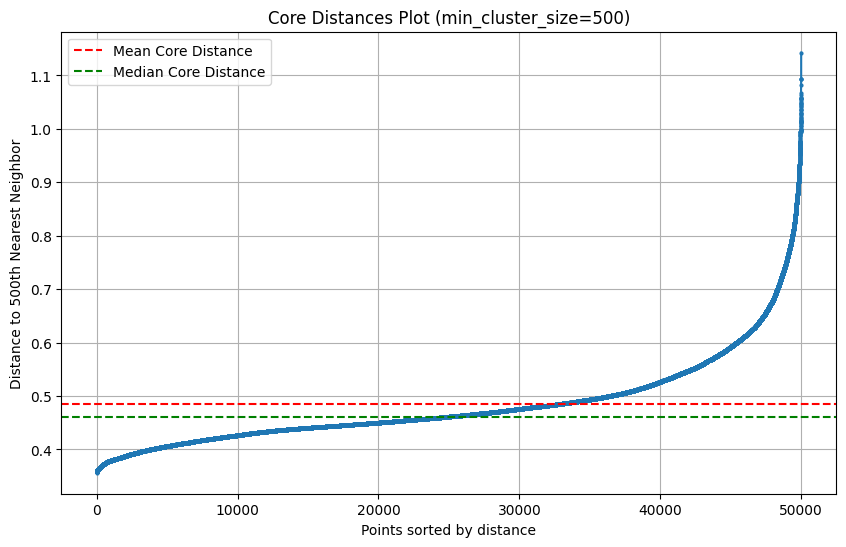

Plotting core distances for n_neighbours=20...


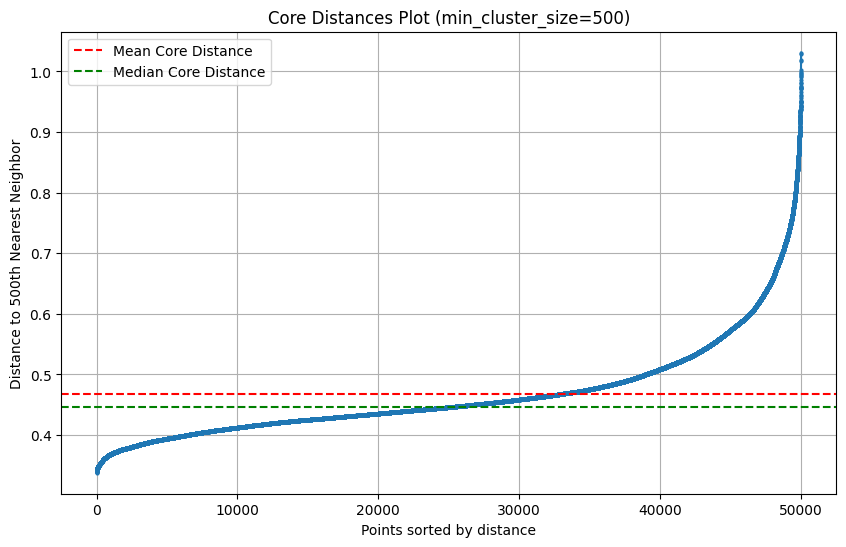

Plotting core distances for n_neighbours=50...


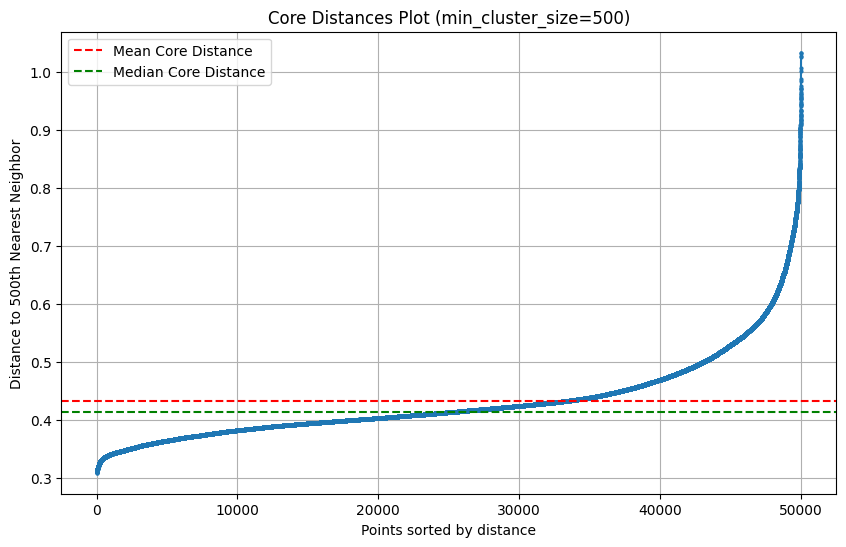

Plotting core distances for n_neighbours=100...


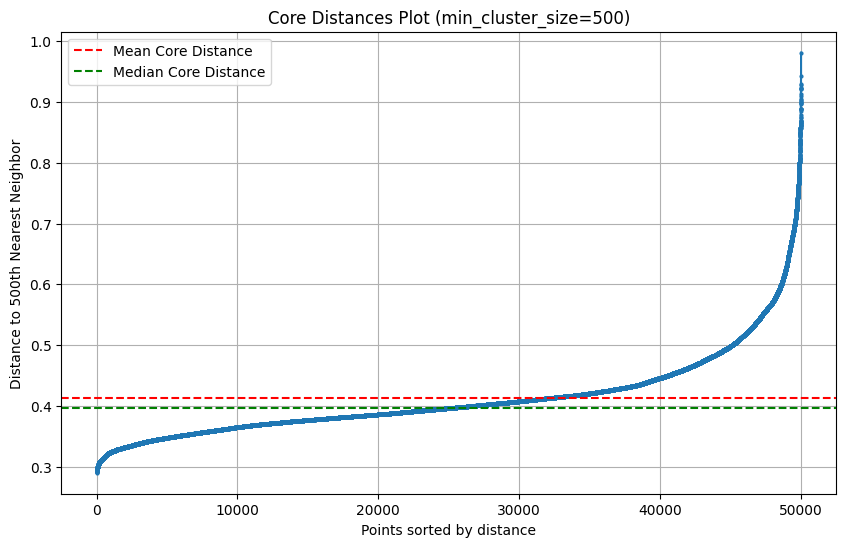

Plotting core distances for n_neighbours=200...


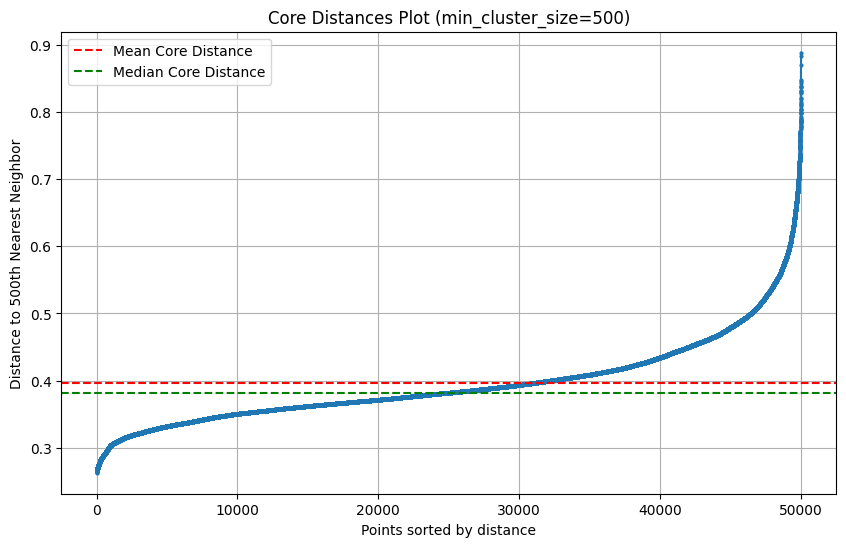

Plotting core distances for n_neighbours=500...


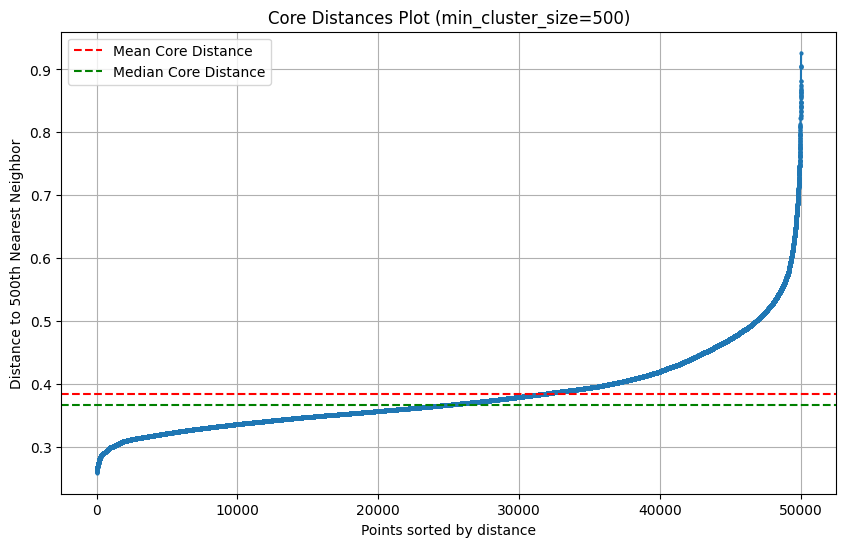

Plotting core distances for n_neighbours=1000...


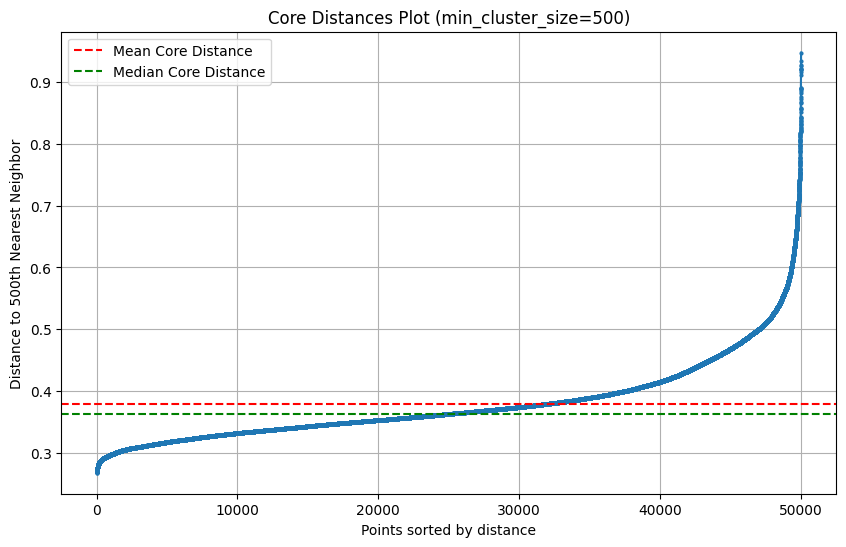

Plotting core distances for n_neighbours=2000...


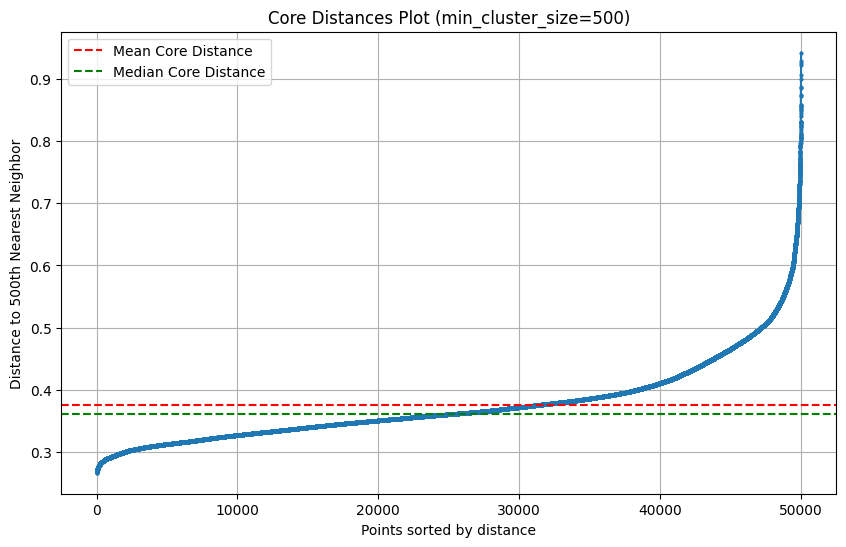

Plotting core distances for n_neighbours=5000...


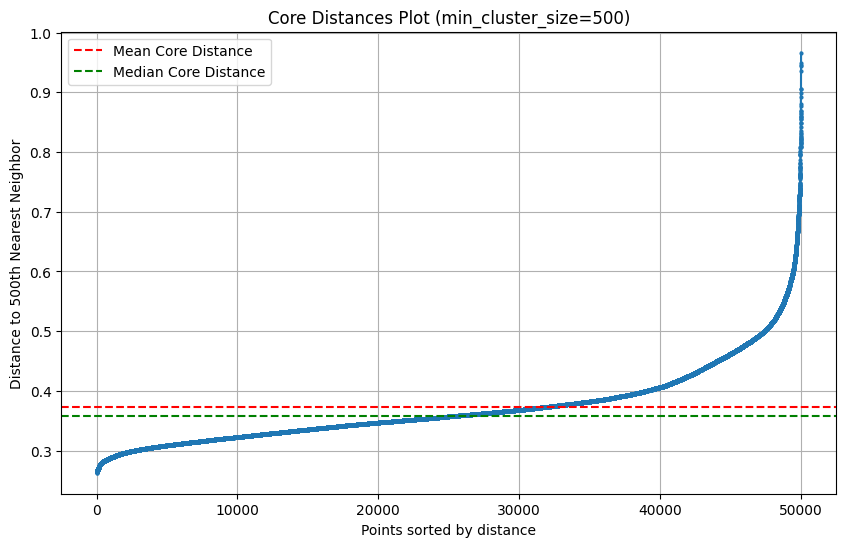

In [6]:
def plot_core_distances(data, min_cluster_size):
    """
    Plot core distances for a fixed min_cluster_size (used in HDBSCAN).
    
    Parameters:
    - data: The input dataset (e.g., UMAP embedding).
    - min_cluster_size: The min_cluster_size parameter for HDBSCAN.
    """
    # Fit Nearest Neighbours to compute distances
    neighbours = NearestNeighbors(n_neighbors=min_cluster_size)
    neighbours_fit = neighbours.fit(data)
    distances, _ = neighbours_fit.kneighbors(data)
    
    # Sort the distances (core distances for each point)
    core_distances = np.sort(distances[:, -1])  # Core distance is the distance to the kth nearest neighbor
    plt.figure(figsize=(10, 6))
    plt.plot(core_distances, marker='o', markersize=2)
    plt.axhline(y=np.mean(core_distances), color='r', linestyle='--', label='Mean Core Distance')
    plt.axhline(y=np.median(core_distances), color='g', linestyle='--', label='Median Core Distance')
    plt.title(f'Core Distances Plot (min_cluster_size={min_cluster_size})')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {min_cluster_size}th Nearest Neighbor')
    plt.legend()
    plt.grid()
    plt.show()

# Example: Plot core distances for each n_neighbours value in the dataset
for n_neighbours in n_neighbours_values:
    umap_embedding = umap_results[n_neighbours]  # Retrieve the UMAP embedding
    print(f"Plotting core distances for n_neighbours={n_neighbours}...")
    plot_core_distances(umap_embedding, min_cluster_size=500)

UMAP embeddings loaded from C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_unclustered/umap_embeddings.pkl
Running HDBSCAN on UMAP embedding with n_neighbours=3...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 200, 'min_samples': 15}
Number of clusters: 2, Noise points: 1311
Silhouette Score: 0.11057574301958084
Running HDBSCAN on UMAP embedding with n_neighbours=5...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 100, 'min_samples': 500}
Number of clusters: 2, Noise points: 3356
Silhouette Score: 0.1610381007194519
Running HDBSCAN on UMAP embedding with n_neighbours=10...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 4000, 'min_samples': 5}
Number of clusters: 2, Noise points: 17742
Silhouette Score: 0.12084022164344788
Running HDBSCAN on UMAP embedding with n_neighbours=15...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 200, 'min_samples': 100}
Number of clusters: 2, Noise points: 6991
Silhouette Score: 0.12738673388957977
Running HDBSCAN on UMAP embedding with n_neighbours=20...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 200, 'min_samples': 200}
Number of clusters: 2, Noise points: 8427
Silhouette Score: 0.12356126308441162
Running HDBSCAN on UMAP embedding with n_neighbours=50...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 100, 'min_samples': 500}
Number of clusters: 3, Noise points: 6903
Silhouette Score: 0.23801247775554657
Running HDBSCAN on UMAP embedding with n_neighbours=100...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 100, 'min_samples': 200}
Number of clusters: 2, Noise points: 2581
Silhouette Score: 0.17126834392547607
Running HDBSCAN on UMAP embedding with n_neighbours=200...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 200, 'min_samples': 10}
Number of clusters: 2, Noise points: 2915
Silhouette Score: 0.12951913475990295
Running HDBSCAN on UMAP embedding with n_neighbours=500...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 4000, 'min_samples': 20}
Number of clusters: 2, Noise points: 7236
Silhouette Score: 0.2113148272037506
Running HDBSCAN on UMAP embedding with n_neighbours=1000...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 4000, 'min_samples': 200}
Number of clusters: 2, Noise points: 8278
Silhouette Score: 0.20430120825767517
Running HDBSCAN on UMAP embedding with n_neighbours=2000...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 4000, 'min_samples': 200}
Number of clusters: 2, Noise points: 8503
Silhouette Score: 0.20032969117164612
Running HDBSCAN on UMAP embedding with n_neighbours=5000...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 4000, 'min_samples': 100}
Number of clusters: 2, Noise points: 7899
Silhouette Score: 0.21485164761543274
Metadata saved to C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_clustered\HDBSCAN_plot_metadata.csv


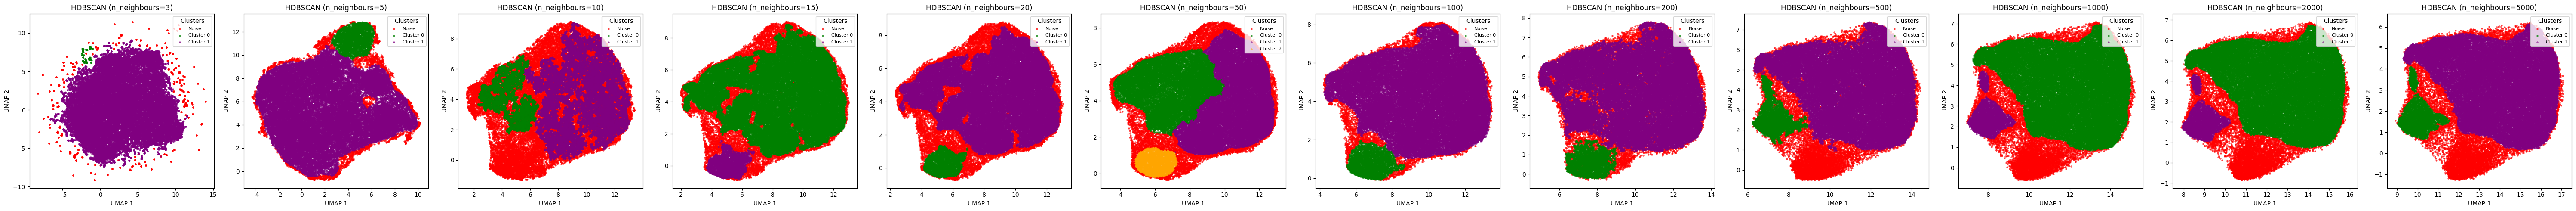

In [7]:
save_dir = r"C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_clustered"
os.makedirs(save_dir, exist_ok=True)

# Initialize results and metadata
hdbscan_results = {}
plot_metadata = []
#n_neighbours_values = [3]#, 5, 10, 15, 20, 50, 100, 200, 500]
# Define a fixed color palette for clusters
fixed_colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'olive', 'cyan', 'magenta', 'gray', 'red']
color_map_fixed = ListedColormap(fixed_colors[:11])

# Shared plot for HDBSCAN clustering
fig, axes = plt.subplots(1, len(n_neighbours_values), figsize=(5 * len(n_neighbours_values), 5))
if len(n_neighbours_values) == 1:
    axes = [axes]

umap_pickle_path = r"C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_unclustered/umap_embeddings.pkl"

# Load UMAP results from pickle
with open(umap_pickle_path, 'rb') as f:
    umap_results = pickle.load(f)

print(f"UMAP embeddings loaded from {umap_pickle_path}")

# Parameter ranges
min_cluster_sizes = [100, 200, 500, 1000, 2000, 4000]
min_samples_values = [5, 10, 15, 20, 100, 200, 500, 1000]
# Perform HDBSCAN clustering
for i, n_neighbours in enumerate(n_neighbours_values):
    try:
        print(f"Running HDBSCAN on UMAP embedding with n_neighbours={n_neighbours}...")
        umap_embedding = umap_results[n_neighbours]
        
        best_score = -1
        best_params = {}
        best_labels = None
        
        # Hyperparameter tuning loop
        for min_cluster_size in tqdm(min_cluster_sizes):
            for min_samples in min_samples_values:
                clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
                labels = clusterer.fit_predict(umap_embedding)
                
                if len(set(labels)) > 1:  # Valid clustering (more than one cluster)
                    silhouette_avg = silhouette_score(umap_embedding, labels)
                    
                    # Using silhouette score for optimization
                    if silhouette_avg > best_score:
                        best_score = silhouette_avg
                        best_params = {'min_cluster_size': min_cluster_size, 'min_samples': min_samples}
                        best_labels = labels
        
        hdbscan_results[n_neighbours] = best_labels
        num_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
        num_noise = np.sum(best_labels == -1)
        
        print(f"Best parameters: {best_params}")
        print(f"Number of clusters: {num_clusters}, Noise points: {num_noise}")
        print(f"Silhouette Score: {best_score}")
        
        # Plot individual results
        fig_individual, ax_individual = plt.subplots(figsize=(8, 6))
        unique_labels = np.unique(best_labels)
        
        if num_clusters > 10:
            ax_individual.text(
                0.5, 0.5, f"{num_clusters} clusters\n{num_noise} noise points", 
                horizontalalignment='center', verticalalignment='center',
                transform=ax_individual.transAxes, fontsize=12
            )
        else:
            for label in unique_labels:
                color = fixed_colors[label + 1] if label != -1 else 'red'
                ax_individual.scatter(
                    umap_embedding[best_labels == label, 0],
                    umap_embedding[best_labels == label, 1],
                    color=color,
                    label=f"Cluster {label}" if label != -1 else "Noise",
                    s=5,
                    alpha=0.6
                )
            ax_individual.legend(title="Clusters", loc='upper right', fontsize=14)
        
        ax_individual.set_title(
            f"HDBSCAN (n_neighbours={n_neighbours}, min_cluster_size={best_params['min_cluster_size']}, min_samples={best_params['min_samples']}, Silhouette Score: {best_score:.3f})"
        , fontsize=16, fontweight='bold')
        ax_individual.set_xlabel('UMAP 1', fontsize=16, fontweight='bold')
        ax_individual.set_ylabel('UMAP 2', fontsize=16, fontweight='bold')
        
        # Save individual plot
        file_name = f"HDBSCAN_n_neighbours_{n_neighbours}_minCluster_{best_params['min_cluster_size']}_minSamples_{best_params['min_samples']}.png"
        save_path = os.path.join(save_dir, file_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig_individual)
        
        # Save metadata
        plot_metadata.append({
            'n_neighbours': n_neighbours,
            'file_name': file_name,
            'file_path': save_path,
            'num_clusters': num_clusters,
            'num_noise': num_noise,
            'best_min_cluster_size': best_params['min_cluster_size'],
            'best_min_samples': best_params['min_samples'],
            'silhouette_score': best_score,
            'description': f"HDBSCAN clustering with n_neighbours={n_neighbours}"
        })
        
        # Shared subplot
        if num_clusters > 10:
            axes[i].text(
                0.5, 0.5, f"{num_clusters} clusters\n{num_noise} noise points",
                horizontalalignment='center', verticalalignment='center',
                transform=axes[i].transAxes, fontsize=12
            )
        else:
            for label in unique_labels:
                color = fixed_colors[label + 1] if label != -1 else 'red'
                axes[i].scatter(
                    umap_embedding[best_labels == label, 0],
                    umap_embedding[best_labels == label, 1],
                    color=color,
                    label=f"Cluster {label}" if label != -1 else "Noise",
                    s=5,
                    alpha=0.6
                )
            axes[i].legend(title="Clusters", loc='upper right', fontsize=8)
        axes[i].set_title(f"HDBSCAN (n_neighbours={n_neighbours})")
        axes[i].set_xlabel('UMAP 1')
        axes[i].set_ylabel('UMAP 2')
    
    except Exception as e:
        print(f"Error with n_neighbours={n_neighbours}: {e}")
        axes[i].axis('off')
        axes[i].set_title(f"n_neighbours={n_neighbours}\nError: {e}")
        plot_metadata.append({
            'n_neighbours': n_neighbours,
            'file_name': None,
            'file_path': None,
            'num_clusters': None,
            'num_noise': None,
            'description': f"Error: {e}"
        })

# Save metadata
metadata_df = pd.DataFrame(plot_metadata)
metadata_csv_path = os.path.join(save_dir, "HDBSCAN_plot_metadata.csv")
metadata_df.to_csv(metadata_csv_path, index=False)
print(f"Metadata saved to {metadata_csv_path}")

# Save shared plot
plt.tight_layout()
plt.show()

Available n_neighbours values: [   3    5   10   15   20   50  100  200  500 1000 2000 5000]


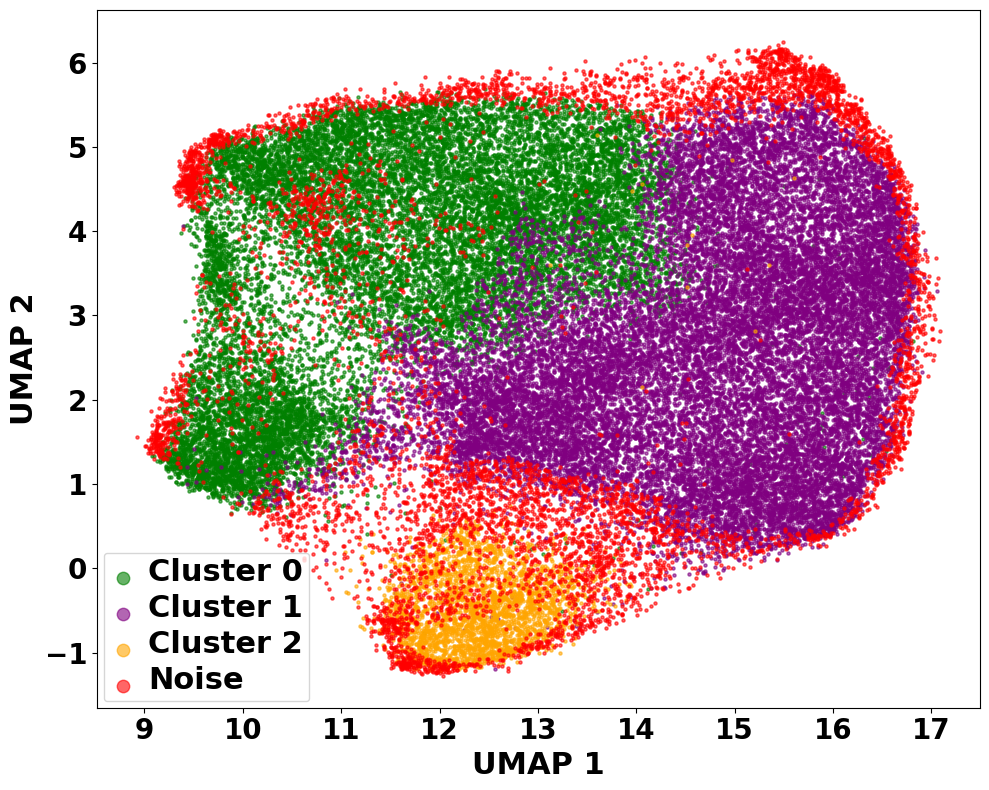

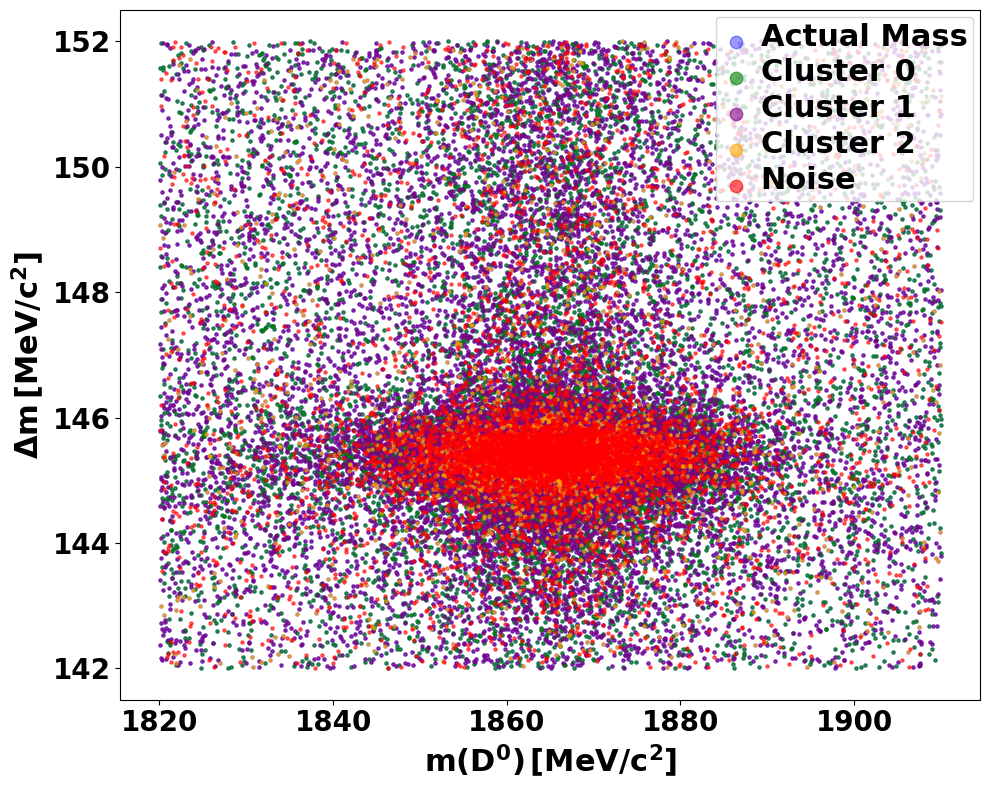

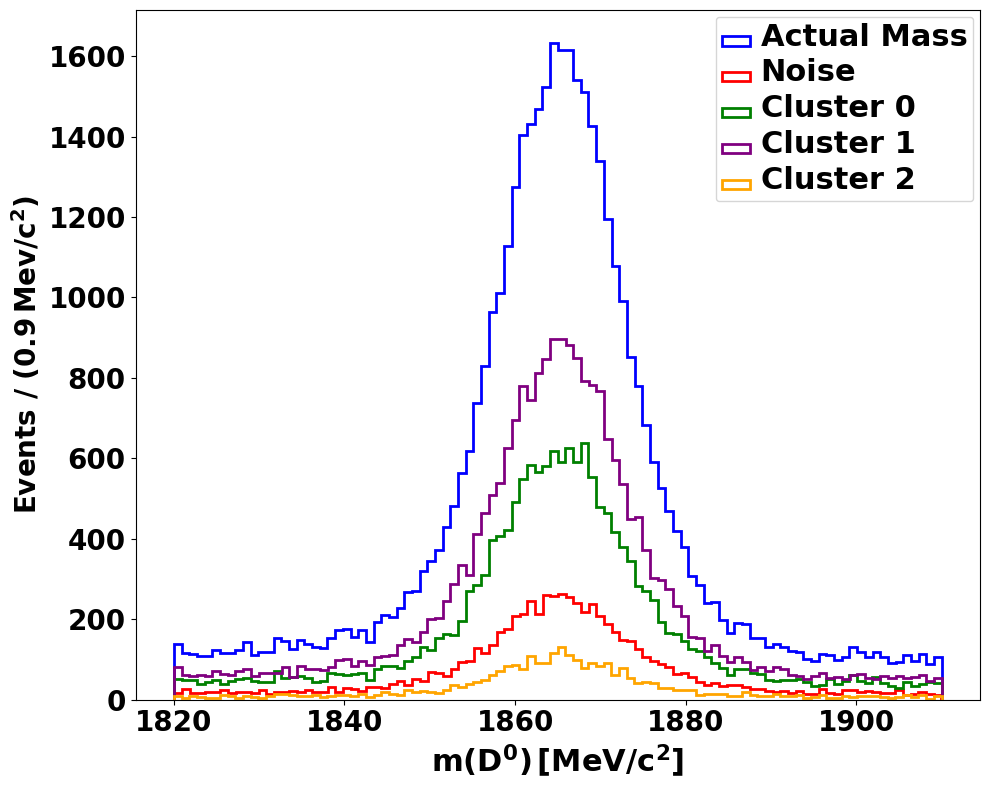

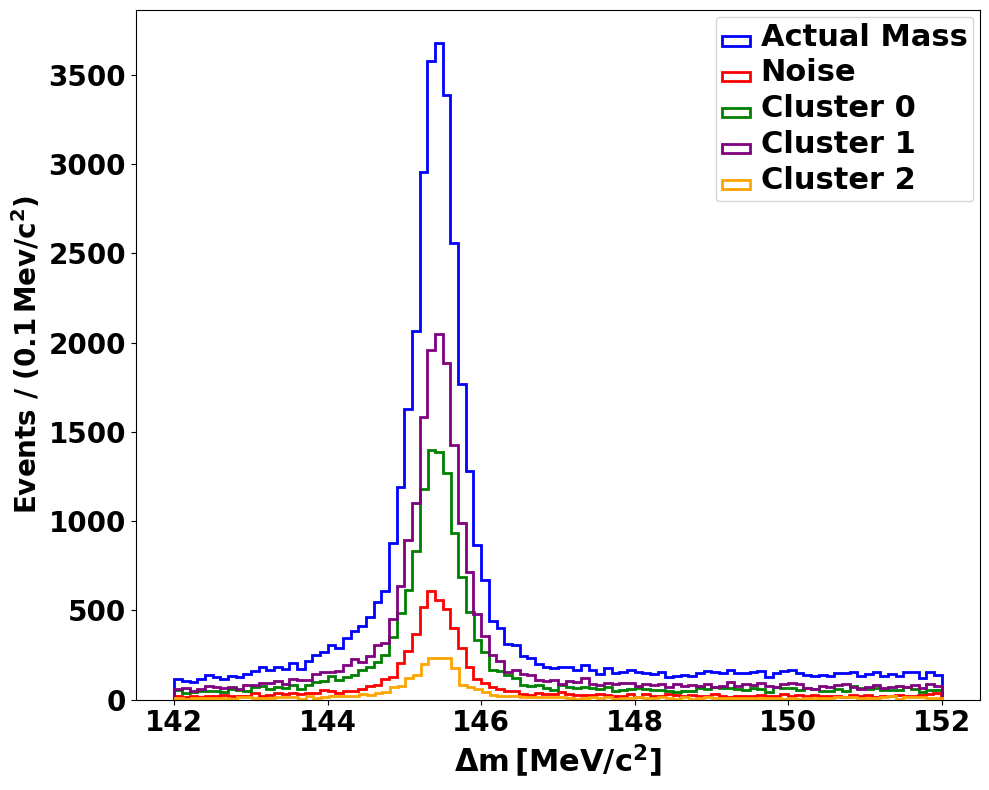

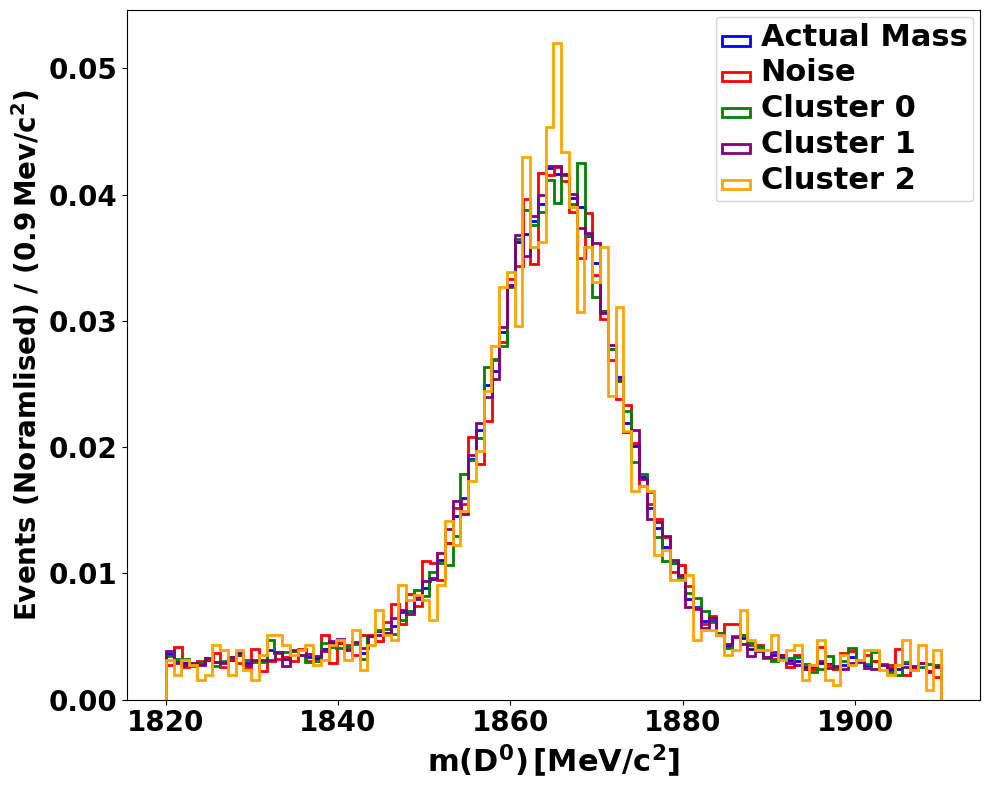

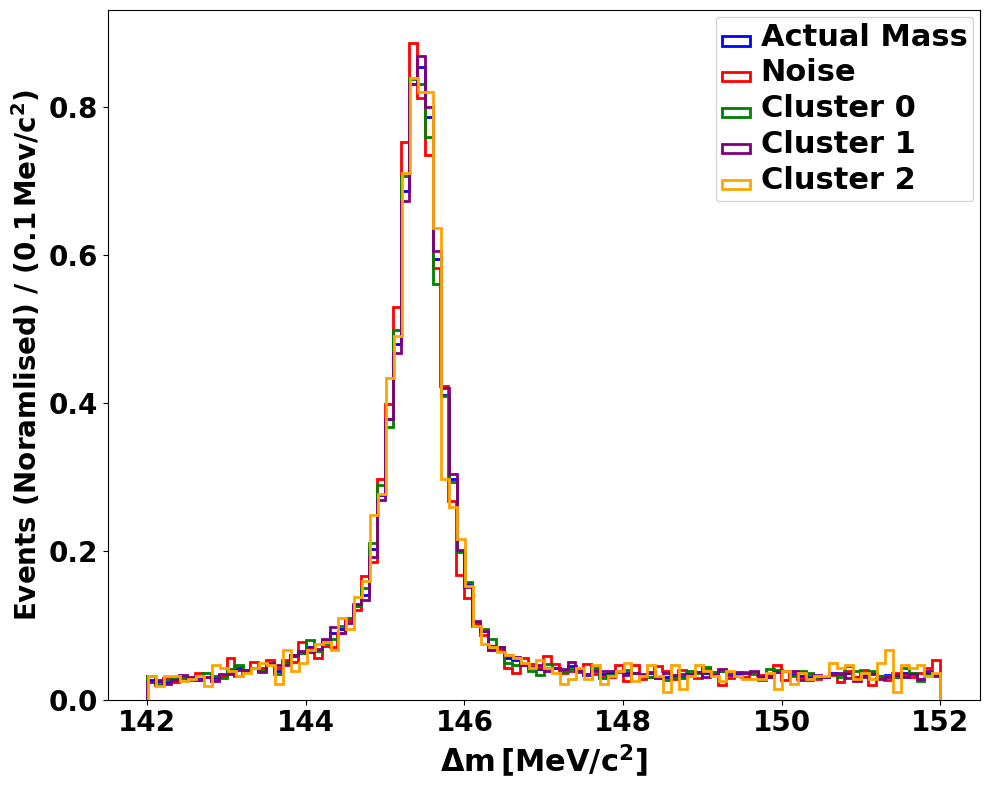

In [48]:
metadata_csv_path = "C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_clustered/HDBSCAN_plot_metadata.csv"
metadata_df = pd.read_csv(metadata_csv_path)

# List available n_neighbours values from the CSV
available_n = metadata_df['n_neighbours'].unique()
print("Available n_neighbours values:", available_n)

n_neighbours = 50

# Ensure the clustering result for n_neighbours = 50 exists
if n_neighbours not in hdbscan_results:
    raise ValueError(f"No clustering result found for n_neighbours={n_neighbours}.")

# Get the cluster labels corresponding to the UMAP embedding events
cluster_labels = hdbscan_results[n_neighbours]

# Create a mask for normal mass ntuples (non-noise events)
mask_normal = (cluster_labels != -1)

# Define fixed_colors if not already defined
# Example: fixed_colors = plt.cm.viridis(np.linspace(0, 1, 10))
# (Ensure you have enough colors for your clusters)

# --------------------------------------------
# UMAP 2D Reduced Clusters Plot
# --------------------------------------------
# (Assumes 'umap_embedding' is a NumPy array of shape (n_samples, 2) containing the UMAP coordinates)
plt.figure(figsize=(10, 8))
# Reorder unique labels to plot noise (-1) last
unique_labels = np.unique(cluster_labels)
ordered_labels = [label for label in unique_labels if label != -1]
if -1 in unique_labels:
    ordered_labels.append(-1)

for label in ordered_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    
    plt.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1],
                s=5, alpha=0.6, c=color, label=label_name, zorder=2)

plt.xlabel("UMAP 1", fontsize=22, fontweight='bold')
plt.ylabel("UMAP 2", fontsize=22, fontweight='bold')
#plt.title(f"UMAP 2D Clusters (n_neighbours = {n_neighbours})", fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
legend = plt.legend(markerscale=4, fontsize=20, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()


# --------------------------------------------
# 1. Scatter Plot: D0_M_data vs. deltam_ReFit_data (Masses Plot)
# --------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: plot normal mass ntuples in blue
plt.scatter(D0_M_data[mask_normal], deltam_ReFit_data[mask_normal],
            s=5, alpha=0.4, c='blue', label='Actual Mass', zorder=1)

# Overlay individual clusters with noise plotted last
for label in ordered_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    
    plt.scatter(D0_M_data[mask], deltam_ReFit_data[mask],
                s=5, alpha=0.6, c=color, label=label_name, zorder=2)

plt.xlabel(r"$\mathbf{m(D^0)\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"$\mathbf{\Delta m\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
#plt.title("Masses Plot with HDBSCAN Clusters (n_neighbours = 50)", fontsize=16, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
legend = plt.legend(markerscale=4, fontsize=20, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()


# --------------------------------------------
# 2. 1D Histogram for D0_M_data
# --------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: normal mass distribution in blue with increased line width
plt.hist(D0_M_data[mask_normal], bins=100, histtype='step', color='blue',
         linewidth=2, label='Actual Mass', zorder=1)

# Overlay individual clusters with thicker lines
for label in unique_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    plt.hist(D0_M_data[mask], bins=100, histtype='step', color=color,
             linewidth=2, label=label_name, zorder=2)

plt.xlabel(r"$\mathbf{m(D^0)\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"Events / $\mathbf{(0.9\,Mev/c^{2})}$", fontsize=20, fontweight='bold')
#plt.title("Mass Distribution with HDBSCAN Clusters (n_neighbours = 50)", fontsize=16, fontweight='bold')
legend = plt.legend(fontsize=20, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


# --------------------------------------------
# 3. 1D Histogram for deltam_ReFit_data
# --------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: normal mass distribution in blue with increased line width
plt.hist(deltam_ReFit_data[mask_normal], bins=100, histtype='step', color='blue',
         linewidth=2, label='Actual Mass', zorder=1)

# Overlay individual clusters with thicker lines
for label in unique_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    plt.hist(deltam_ReFit_data[mask], bins=100, histtype='step', color=color,
             linewidth=2, label=label_name, zorder=2)

plt.xlabel(r"$\mathbf{\Delta m\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"Events / $\mathbf{(0.1\,Mev/c^{2})}$", fontsize=20, fontweight='bold')
#plt.title("Mass Distribution with HDBSCAN Clusters (n_neighbours = 50)", fontsize=16, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
legend = plt.legend( fontsize=30, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()



# --------------------------------------------
# 2. 1D Histogram for D0_M_data
# --------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: normal mass distribution in blue with increased line width
plt.hist(D0_M_data[mask_normal], bins=100, histtype='step', color='blue',
         linewidth=2, label='Actual Mass', zorder=1, density=True)

# Overlay individual clusters with thicker lines
for label in unique_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    plt.hist(D0_M_data[mask], bins=100, histtype='step', color=color,
             linewidth=2, label=label_name, zorder=2, density=True)

plt.xlabel(r"$\mathbf{m(D^0)\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"Events (Noramlised) / $\mathbf{(0.9\,Mev/c^{2})}$", fontsize=20, fontweight='bold')
#plt.title("Mass Distribution with HDBSCAN Clusters (n_neighbours = 50)", fontsize=16, fontweight='bold')
legend = plt.legend(fontsize=20, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


# --------------------------------------------
# 3. 1D Histogram for deltam_ReFit_data
# --------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: normal mass distribution in blue with increased line width
plt.hist(deltam_ReFit_data[mask_normal], bins=100, histtype='step', color='blue',
         linewidth=2, label='Actual Mass', zorder=1, density=True)

# Overlay individual clusters with thicker lines
for label in unique_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    plt.hist(deltam_ReFit_data[mask], bins=100, histtype='step', color=color,
             linewidth=2, label=label_name, zorder=2, density=True)

plt.xlabel(r"$\mathbf{\Delta m\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"Events (Noramlised) / $\mathbf{(0.1\,Mev/c^{2})}$", fontsize=20, fontweight='bold')
#plt.title("Mass Distribution with HDBSCAN Clusters (n_neighbours = 50)", fontsize=16, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
legend = plt.legend( fontsize=30, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()

In [ ]:

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN

save_dir = r"C:\Users\edwar\OneDrive\Documents\Documents\2025\Masters_Thesis\Unsupervised\dim_reduction\HDBSCAN_with_UMAP_and_tSNE\H2D_UMAP_clustered"
os.makedirs(save_dir, exist_ok=True)

dbscan_results = {}
plot_metadata = []

# Define a fixed color palette for up to 10 clusters
fixed_colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'olive', 'cyan', 'magenta', 'gray']
color_map_fixed = ListedColormap(fixed_colors[:11])  # Up to 10 clusters

tsne_pickle_path = r"C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_UMAP_unclustered/tsne_embeddings.pkl"

# Load UMAP results from pickle
if os.path.exists(tsne_pickle_path):
    with open(tsne_pickle_path, 'rb') as f:
        umap_results = pickle.load(f)
else:
    print(f"File not found: {tsne_pickle_path}")

# Define the values for n_neighbours and eps
n_neighbours_values = [5, 10, 15]  # Example values
eps_values = [0.5, 0.6, 0.7]  # Example values

# Create the figure
fig, axes = plt.subplots(1, len(n_neighbours_values), figsize=(5 * len(n_neighbours_values), 5))
if len(n_neighbours_values) == 1:
    axes = [axes]

for i, n_neighbours in enumerate(n_neighbours_values):
    eps = eps_values[i]
    try:
        print(f"Running DBSCAN on UMAP embedding with n_neighbours={n_neighbours}...")
        umap_embedding = umap_results[n_neighbours]
        dbscan = DBSCAN(eps=eps, min_samples=4)
        labels = dbscan.fit_predict(umap_embedding)
        dbscan_results[n_neighbours] = labels
        
        # Filter out the noise points (labeled as -1)
        mask = labels != -1
        filtered_embedding = umap_embedding[mask]
        filtered_labels = labels[mask]
        
        num_clusters = len(set(filtered_labels))  # Unique clusters excluding noise
        num_noise = np.sum(labels == -1)
        
        fig_individual, ax_individual = plt.subplots(figsize=(8, 6))
        
        if num_clusters <= 10:
            # Use fixed color mapping for clusters
            unique_labels = np.unique(filtered_labels)
            for label in unique_labels:
                color = fixed_colors[label + 1] if label != -1 else 'red'
                ax_individual.scatter(
                    filtered_embedding[filtered_labels == label, 0],
                    filtered_embedding[filtered_labels == label, 1],
                    color=color,
                    label=f"Cluster {label}" if label != -1 else "Noise",
                    s=5,
                    alpha=0.6
                )
            ax_individual.legend(title="Clusters", loc='upper right', fontsize=8)
        else:
            # Use gradient colormap for >10 clusters
            scatter = ax_individual.scatter(
                filtered_embedding[:, 0], 
                filtered_embedding[:, 1], 
                c=filtered_labels, 
                cmap='Spectral', 
                s=5, 
                alpha=0.6
            )
            plt.colorbar(scatter, ax=ax_individual, label='Cluster Label')
        
        ax_individual.set_title(f"DBSCAN (n_neighbours={n_neighbours}) - No Noise")
        ax_individual.set_xlabel('UMAP 1')
        ax_individual.set_ylabel('UMAP 2')
        
        # Save individual plot
        file_name = f"DBSCAN_n_neighbours_{n_neighbours}_Clusters_Without_Noise.png"
        save_path = os.path.join(save_dir, file_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig_individual)
        
        plot_metadata.append({
            'n_neighbours': n_neighbours,
            'file_name': file_name,
            'file_path': save_path,
            'num_clusters': num_clusters,
            'num_noise': num_noise,
            'description': f"DBSCAN clustering with n_neighbours={n_neighbours} - Excluding noise"
        })
        
        # Add to shared subplot
        if num_clusters <= 10:
            for label in np.unique(filtered_labels):
                color = fixed_colors[label + 1] if label != -1 else 'red'
                axes[i].scatter(
                    filtered_embedding[filtered_labels == label, 0],
                    filtered_embedding[filtered_labels == label, 1],
                    color=color,
                    label=f"Cluster {label}" if label != -1 else "Noise",
                    s=5,
                    alpha=0.6
                )
            axes[i].legend(title="Clusters", loc='upper right', fontsize=8)
        else:
            scatter = axes[i].scatter(
                filtered_embedding[:, 0], 
                filtered_embedding[:, 1], 
                c=filtered_labels, 
                cmap='Spectral', 
                s=5, 
                alpha=0.6
            )
            plt.colorbar(scatter, ax=axes[i], label='Cluster Label')
        
        axes[i].set_title(f"DBSCAN (n_neighbours={n_neighbours}) - No Noise")
        axes[i].set_xlabel('UMAP 1')
        axes[i].set_ylabel('UMAP 2')
    
    except Exception as e:
        print(f"Error with n_neighbours={n_neighbours}: {e}")
        axes[i].axis('off')
        axes[i].set_title(f"n_neighbours={n_neighbours}\nError: {e}")
        plot_metadata.append({
            'n_neighbours': n_neighbours,
            'file_name': None,
            'file_path': None,
            'num_clusters': None,
            'num_noise': None,
            'description': f"Error: {e}"
        })

# Save metadata to CSV
metadata_df = pd.DataFrame(plot_metadata)
metadata_csv_path = os.path.join(save_dir, "DBSCAN_plot_metadata_no_noise.csv")
metadata_df.to_csv(metadata_csv_path, index=False)
print(f"Metadata saved to {metadata_csv_path}")

# Save shared plot
shared_plot_path = os.path.join(save_dir, "DBSCAN_combined_plot_no_noise.png")
plt.tight_layout()
plt.savefig(shared_plot_path, dpi=300, bbox_inches='tight')
print(f"Shared plot saved to {shared_plot_path}")

plt.show()

Running HDBSCAN on t-SNE embedding with perplexity=5...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 200, 'min_samples': 5}
Number of clusters: 2, Noise points: 1864
Silhouette Score: 0.045967407524585724
Running HDBSCAN on t-SNE embedding with perplexity=15...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 1000, 'min_samples': 10}
Number of clusters: 2, Noise points: 3451
Silhouette Score: 0.06098240241408348
Running HDBSCAN on t-SNE embedding with perplexity=30...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 500, 'min_samples': 5}
Number of clusters: 2, Noise points: 3179
Silhouette Score: 0.05901510268449783
Running HDBSCAN on t-SNE embedding with perplexity=50...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 1000, 'min_samples': 5}
Number of clusters: 2, Noise points: 5769
Silhouette Score: 0.0786963403224945
Running HDBSCAN on t-SNE embedding with perplexity=100...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 4000, 'min_samples': 500}
Number of clusters: 2, Noise points: 13689
Silhouette Score: 0.19328685104846954
Running HDBSCAN on t-SNE embedding with perplexity=200...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 100, 'min_samples': 500}
Number of clusters: 3, Noise points: 3989
Silhouette Score: 0.24784018099308014
Running HDBSCAN on t-SNE embedding with perplexity=500...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 100, 'min_samples': 500}
Number of clusters: 2, Noise points: 660
Silhouette Score: 0.18380656838417053
Running HDBSCAN on t-SNE embedding with perplexity=1000...


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\tf_uproot_env\lib\site-packages\sklearn\utils\deprecation.py:151:

Best parameters: {'min_cluster_size': 4000, 'min_samples': 200}
Number of clusters: 3, Noise points: 10009
Silhouette Score: 0.22729454934597015
Metadata saved to C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_tSNE_clustered\HDBSCAN_plot_metadata.csv


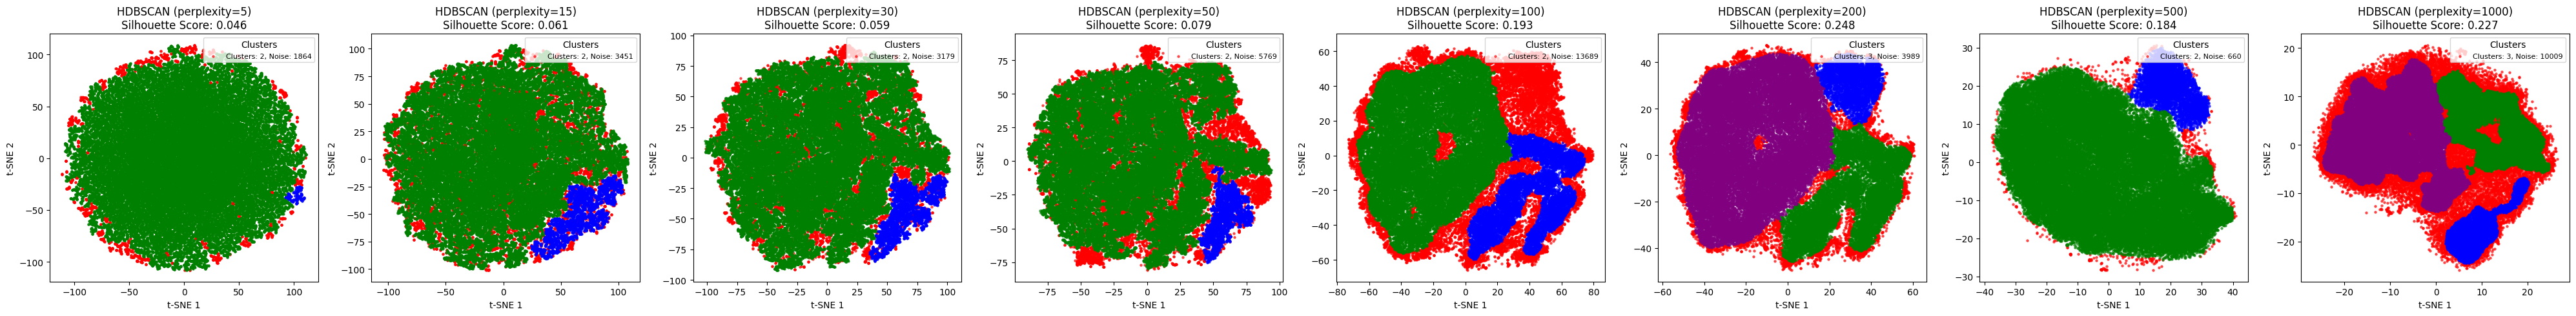

In [9]:
save_dir = r"C:/Users/edwar/OneDrive/Documents/Documents/2025/Masters_Thesis/Unsupervised/dim_reduction/HDBSCAN_with_UMAP_and_tSNE/H2D_tSNE_clustered"
os.makedirs(save_dir, exist_ok=True)

# Initialize results and metadata
hdbscan_tsne_results = {}
plot_metadata = []

# Define a fixed color palette for clusters
fixed_colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'olive', 'cyan', 'magenta', 'gray', 'red']
color_map_fixed = ListedColormap(fixed_colors[:11])

# Shared plot for HDBSCAN clustering
fig, axes = plt.subplots(1, len(perplexity_values), figsize=(5 * len(perplexity_values), 5))
if len(perplexity_values) == 1:
    axes = [axes]

# Parameter ranges
min_cluster_sizes = [100,200,500,1000,2000,4000]#[2, 3]#, 4, 5]
min_samples_values = [5, 10, 15, 20, 100, 200, 500, 1000] #[50, 75, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Perform HDBSCAN clustering
for i, perplexity in enumerate(perplexity_values):
    try:
        print(f"Running HDBSCAN on t-SNE embedding with perplexity={perplexity}...")
        tsne_embedding = tsne_results[perplexity]
        
        best_score = -1
        best_params = {}
        best_labels = None
        
        # Hyperparameter tuning loop
        for min_cluster_size in tqdm(min_cluster_sizes):
            for min_samples in min_samples_values:
                clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
                labels = clusterer.fit_predict(tsne_embedding)
                
                if len(set(labels)) > 1:  # Valid clustering (more than one cluster)
                    silhouette_avg = silhouette_score(tsne_embedding, labels)
                    
                    # Using silhouette score for optimization
                    if silhouette_avg > best_score:
                        best_score = silhouette_avg
                        best_params = {'min_cluster_size': min_cluster_size, 'min_samples': min_samples}
                        best_labels = labels
        
        hdbscan_tsne_results[perplexity] = best_labels
        num_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
        num_noise = np.sum(best_labels == -1)
        
        print(f"Best parameters: {best_params}")
        print(f"Number of clusters: {num_clusters}, Noise points: {num_noise}")
        print(f"Silhouette Score: {best_score}")
        
        # Plot individual results
        fig_individual, ax_individual = plt.subplots(figsize=(8, 6))
        unique_labels = np.unique(best_labels)

        if num_clusters > 10:
            for label in unique_labels:
                color = fixed_colors[label % len(fixed_colors)] if label != -1 else 'red'
                ax_individual.scatter(
                    tsne_embedding[best_labels == label, 0],
                    tsne_embedding[best_labels == label, 1],
                    color=color,
                    s=5,
                    alpha=0.6
                )
            ax_individual.set_title(
            f"HDBSCAN (perplexity={perplexity}, min_cluster_size={best_params['min_cluster_size']}, min_samples={best_params['min_samples']},\nSilhouette Score: {best_score:.3f}")
            ax_individual.legend(title="Clusters", loc='upper right', fontsize=8, labels=[f"Clusters: {num_clusters}, Noise: {num_noise}"])
        else:
            for label in unique_labels:
                color = fixed_colors[label + 1] if label != -1 else 'red'
                ax_individual.scatter(
                    tsne_embedding[best_labels == label, 0],
                    tsne_embedding[best_labels == label, 1],
                    color=color,
                    label=f"Cluster {label}" if label != -1 else "Noise",
                    s=5,
                    alpha=0.6
                )
            ax_individual.legend(title="Clusters", loc='upper right', fontsize=8)

        ax_individual.set_title(
            f"HDBSCAN (perplexity={perplexity}, min_cluster_size={best_params['min_cluster_size']}, min_samples={best_params['min_samples']})"
        )
        ax_individual.set_xlabel('t-SNE 1')
        ax_individual.set_ylabel('t-SNE 2')
        
        # Save individual plot
        file_name = f"HDBSCAN_perplexity_{perplexity}_minCluster_{best_params['min_cluster_size']}_minSamples_{best_params['min_samples']}.png"
        save_path = os.path.join(save_dir, file_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig_individual)
        
        # Save metadata
        plot_metadata.append({
            'perplexity': perplexity,
            'file_name': file_name,
            'file_path': save_path,
            'num_clusters': num_clusters,
            'num_noise': num_noise,
            'best_min_cluster_size': best_params['min_cluster_size'],
            'best_min_samples': best_params['min_samples'],
            'silhouette_score': best_score,
            'description': f"HDBSCAN clustering with perplexity={perplexity}"
        })

        # Shared subplot
        for label in unique_labels:
            color = fixed_colors[label % len(fixed_colors)] if label != -1 else 'red'
            axes[i].scatter(
                tsne_embedding[best_labels == label, 0],
                tsne_embedding[best_labels == label, 1],
                color=color,
                s=5,
                alpha=0.6
            )
        axes[i].legend(title="Clusters", loc='upper right', fontsize=8, labels=[f"Clusters: {num_clusters}, Noise: {num_noise}"])
        axes[i].set_title(f"HDBSCAN (perplexity={perplexity})\nSilhouette Score: {best_score:.3f}")
        axes[i].set_xlabel('t-SNE 1')
        axes[i].set_ylabel('t-SNE 2')
    
    except Exception as e:
        print(f"Error with perplexity={perplexity}: {e}")
        axes[i].axis('off')
        axes[i].set_title(f"perplexity={perplexity}\nError: {e}")
        plot_metadata.append({
            'perplexity': perplexity,
            'file_name': None,
            'file_path': None,
            'num_clusters': None,
            'num_noise': None,
            'description': f"Error: {e}"
        })

# Save metadata
metadata_df = pd.DataFrame(plot_metadata)
metadata_csv_path = os.path.join(save_dir, "HDBSCAN_plot_metadata.csv")
metadata_df.to_csv(metadata_csv_path, index=False)
print(f"Metadata saved to {metadata_csv_path}")

# Save shared plot
plt.tight_layout()
plt.show()

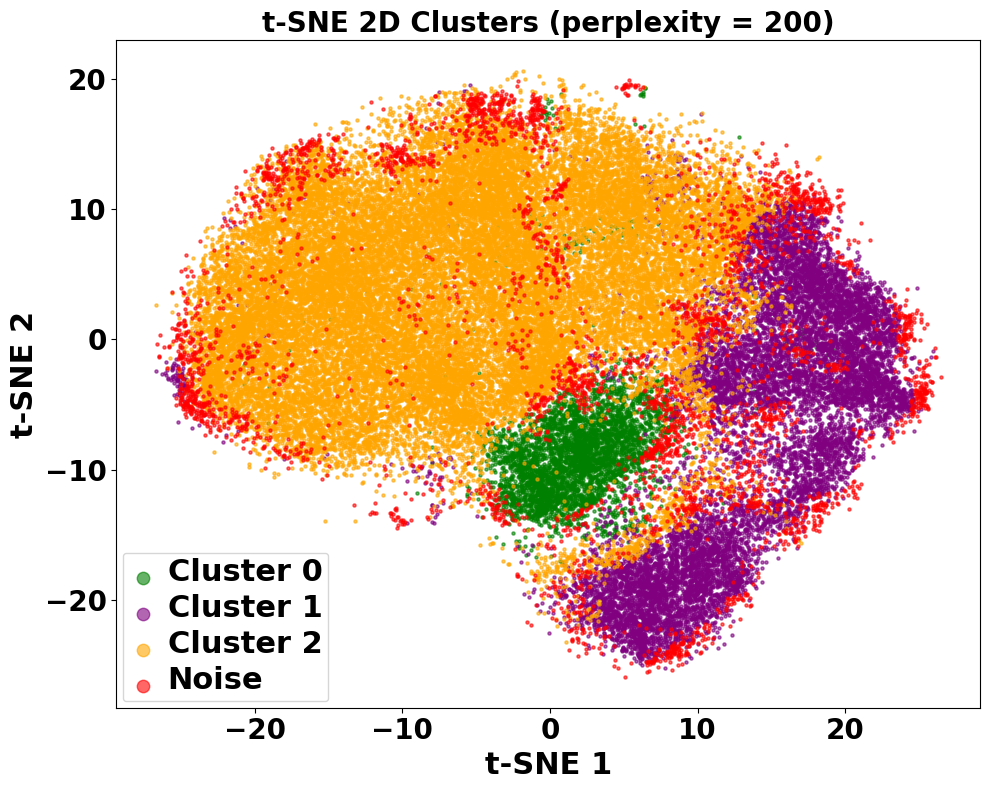

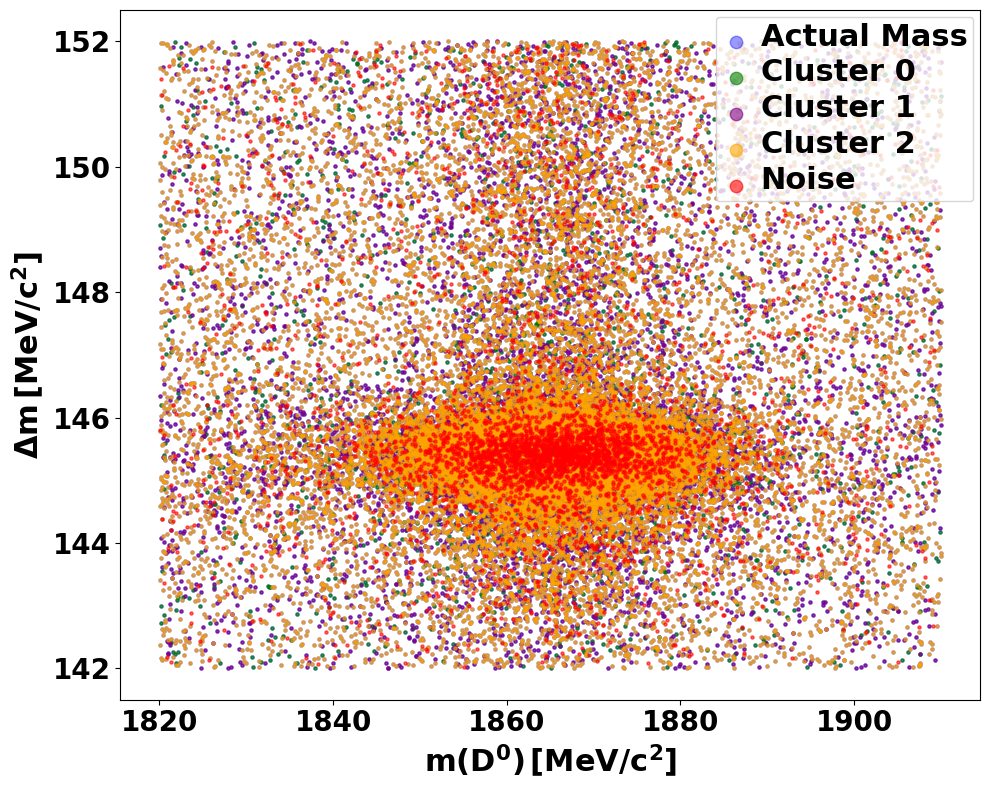

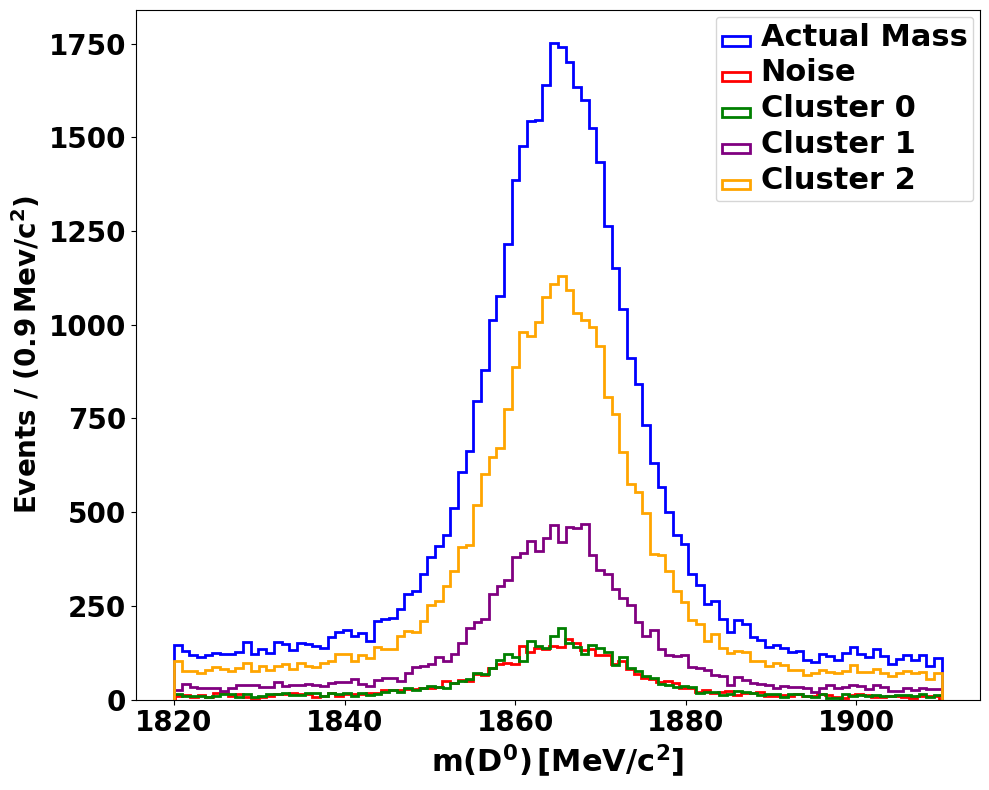

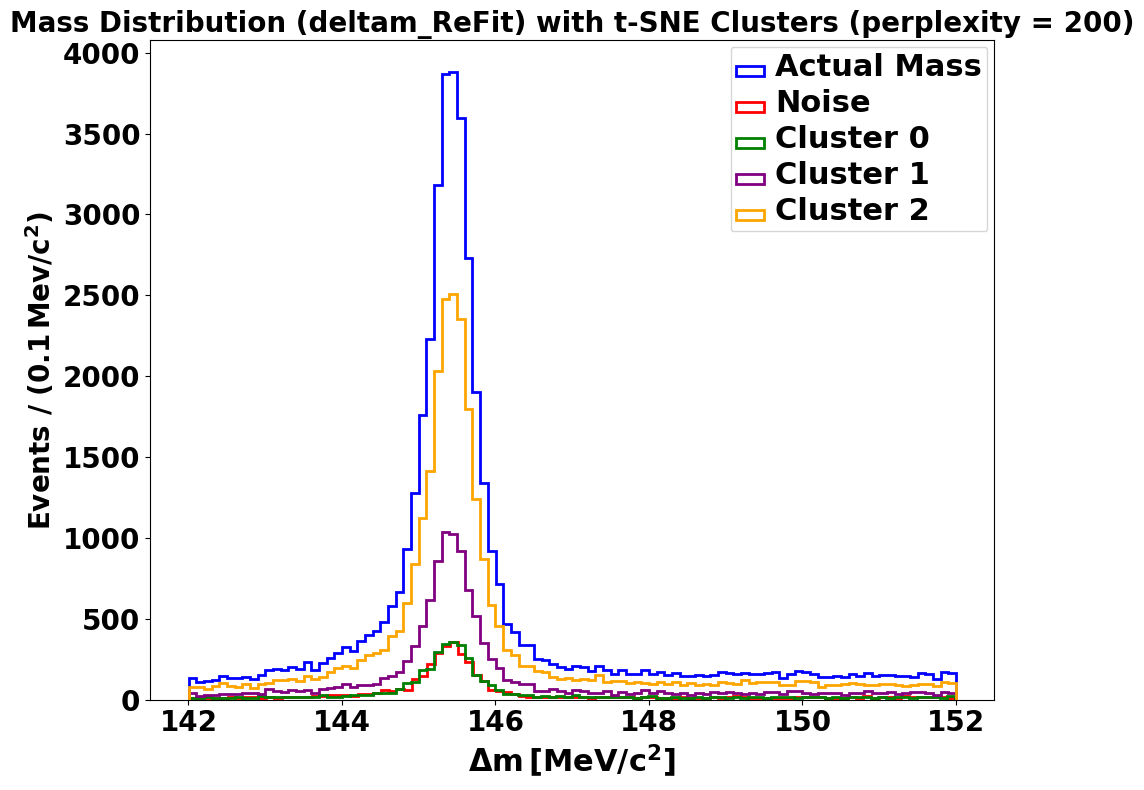

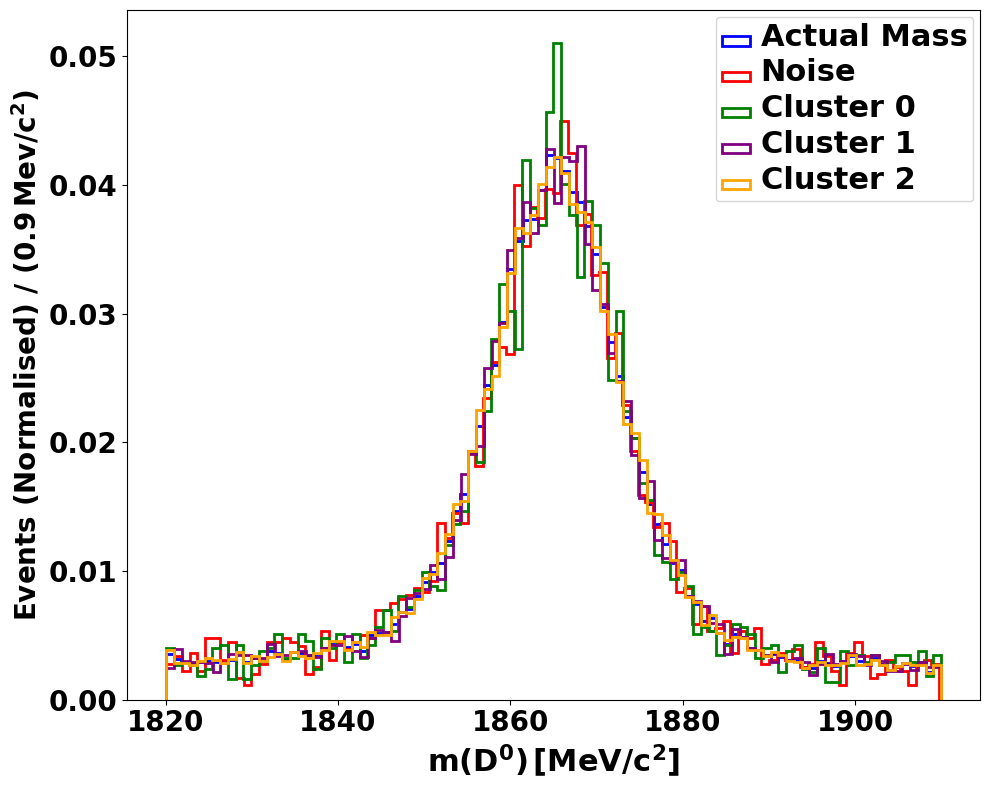

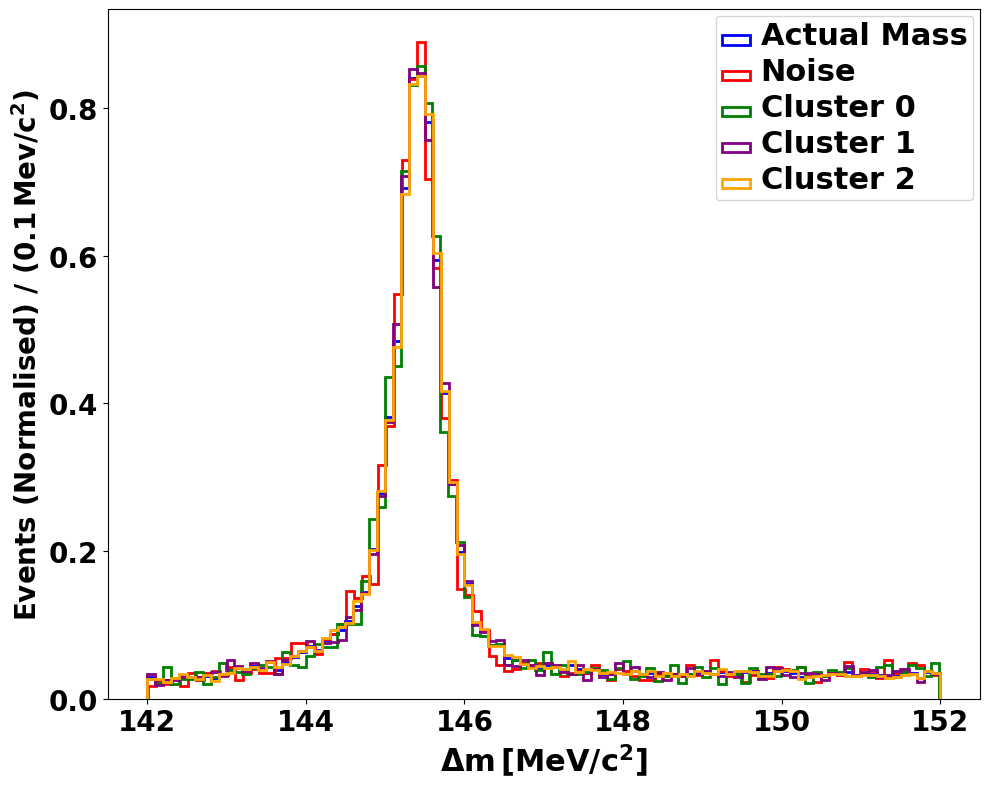

In [52]:
# Select the perplexity value you want to inspect (e.g., 100)
selected_perplexity = 200
if selected_perplexity not in hdbscan_tsne_results:
    raise ValueError(f"No clustering result found for perplexity = {selected_perplexity}.")

# Extract the clustering labels for the selected perplexity
cluster_labels = hdbscan_tsne_results[selected_perplexity]
# Create a mask for normal mass ntuples (non-noise events)
mask_normal = (cluster_labels != -1)

# --------------------------------------------
# t-SNE 2D Reduced Clusters Plot
# --------------------------------------------
# (Assumes 'umap_embedding' is a NumPy array of shape (n_samples, 2) containing the UMAP coordinates)
plt.figure(figsize=(10, 8))
# Reorder unique labels to plot noise (-1) last
unique_labels = np.unique(cluster_labels)
ordered_labels = [label for label in unique_labels if label != -1]
if -1 in unique_labels:
    ordered_labels.append(-1)

for label in ordered_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    
    plt.scatter(tsne_embedding[mask, 0], tsne_embedding[mask, 1],
                s=5, alpha=0.6, c=color, label=label_name, zorder=2)

plt.xlabel("t-SNE 1", fontsize=22, fontweight='bold')
plt.ylabel("t-SNE 2", fontsize=22, fontweight='bold')
plt.title(f"t-SNE 2D Clusters (perplexity = {selected_perplexity})", fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
legend = plt.legend(markerscale=4, fontsize=20, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 1. Scatter Plot: D0_M_data vs. deltam_ReFit_data
# --------------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: plot normal mass ntuples in blue
plt.scatter(D0_M_data[mask_normal], deltam_ReFit_data[mask_normal],
            s=5, alpha=0.4, c='blue', label='Actual Mass', zorder=1)

# Order the cluster labels to ensure noise (-1) is plotted last
unique_labels = np.unique(cluster_labels)
ordered_labels = [label for label in unique_labels if label != -1]
if -1 in unique_labels:
    ordered_labels.append(-1)

# Overlay each cluster's events
for label in ordered_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'  # Use red for noise
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    
    plt.scatter(D0_M_data[mask], deltam_ReFit_data[mask],
                s=5, alpha=0.6, c=color, label=label_name, zorder=2)

plt.xlabel(r"$\mathbf{m(D^0)\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"$\mathbf{\Delta m\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
#plt.title(f"Masses Plot with t‑SNE Clusters (perplexity = {selected_perplexity})",
#          fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

legend = plt.legend(markerscale=4, fontsize=20, title_fontsize=30, prop={'weight': 'bold'}, loc='upper right')
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 2. 1D Histogram for D0_M_data (Mass Distribution)
# --------------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: normal mass distribution in blue with increased line width
plt.hist(D0_M_data[mask_normal], bins=100, histtype='step', color='blue',
         linewidth=2, label='Actual Mass', zorder=1)
# Overlay clusters
for label in unique_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    
    plt.hist(D0_M_data[mask], bins=100, histtype='step', color=color,
             linewidth=2, label=label_name, zorder=2)

plt.xlabel(r"$\mathbf{m(D^0)\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"Events / $\mathbf{(0.9\,Mev/c^{2})}$", fontsize=20, fontweight='bold')
#plt.title(f"Mass Distribution (Dst_ReFit_D0_M_best) with t‑SNE Clusters (perplexity = {selected_perplexity})",
#          fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

legend = plt.legend(markerscale=4, fontsize=20, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 3. 1D Histogram for deltam_ReFit_data (Mass Distribution)
# --------------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: normal mass distribution in blue with increased line width
plt.hist(deltam_ReFit_data[mask_normal], bins=100, histtype='step', color='blue',
         linewidth=2, label='Actual Mass', zorder=1)
# Overlay clusters
for label in unique_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    
    plt.hist(deltam_ReFit_data[mask], bins=100, histtype='step', color=color,
             linewidth=2, label=label_name, zorder=2)

plt.xlabel(r"$\mathbf{\Delta m\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"Events / $\mathbf{(0.1\,Mev/c^{2})}$", fontsize=20, fontweight='bold')
plt.title(f"Mass Distribution (deltam_ReFit) with t‑SNE Clusters (perplexity = {selected_perplexity})",
          fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

legend = plt.legend(markerscale=4, fontsize=20, title_fontsize=30, prop={'weight': 'bold'}, loc = 'upper right')
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2. 1D Histogram for D0_M_data (Mass Distribution)
# --------------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: normal mass distribution in blue with increased line width
plt.hist(D0_M_data[mask_normal], bins=100, histtype='step', color='blue',
         linewidth=2, label='Actual Mass', zorder=1, density=True)
# Overlay clusters
for label in unique_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    
    plt.hist(D0_M_data[mask], bins=100, histtype='step', color=color,
             linewidth=2, label=label_name, zorder=2, density=True)

plt.xlabel(r"$\mathbf{m(D^0)\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"Events (Normalised) / $\mathbf{(0.9\,Mev/c^{2})}$", fontsize=20, fontweight='bold')
#plt.title(f"Mass Distribution (Dst_ReFit_D0_M_best) with t‑SNE Clusters (perplexity = {selected_perplexity})",
#          fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

legend = plt.legend(markerscale=4, fontsize=20, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 3. 1D Histogram for deltam_ReFit_data (Mass Distribution)
# --------------------------------------------------
plt.figure(figsize=(10, 8))
# Base layer: normal mass distribution in blue with increased line width
plt.hist(deltam_ReFit_data[mask_normal], bins=100, histtype='step', color='blue',
         linewidth=2, label='Actual Mass', zorder=1, density=True)
# Overlay clusters
for label in unique_labels:
    mask = (cluster_labels == label)
    if label == -1:
        label_name = "Noise"
        color = 'red'
    else:
        label_name = f"Cluster {label}"
        color = fixed_colors[(label + 1) % len(fixed_colors)]
    
    plt.hist(deltam_ReFit_data[mask], bins=100, histtype='step', color=color,
             linewidth=2, label=label_name, zorder=2, density=True)

plt.xlabel(r"$\mathbf{\Delta m\,[MeV/c^2]}$", fontsize=22, fontweight='bold')
plt.ylabel(r"Events (Normalised) / $\mathbf{(0.1\,Mev/c^{2})}$", fontsize=20, fontweight='bold')
#plt.title(f"Mass Distribution (deltam_ReFit) with t‑SNE Clusters (perplexity = {selected_perplexity})",
#          fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

legend = plt.legend(markerscale=4, fontsize=20, title_fontsize=30, prop={'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(22)
legend.get_title().set_fontsize(22)
plt.tight_layout()
plt.show()

In [ ]:
dbscan_scores_umap = {}

# Evaluate clustering for each n_neighbours value
for n_neighbours, umap_embedding in umap_results.items():
    print(f"Evaluating DBSCAN clustering for n_neighbours={n_neighbours}...")
    try:
        labels = dbscan_results[n_neighbours]
        
        # Filter noise points (-1 label indicates noise in DBSCAN)
        valid_points = labels != -1
        unique_clusters = np.unique(labels[valid_points])
        
        # Check if there's only one cluster or no valid points
        if len(unique_clusters) <= 1:
            print(f"⚠️ Only one cluster or no valid clusters for n_neighbours={n_neighbours}. Skipping scoring.")
            dbscan_scores_umap[n_neighbours] = {
                'Davies-Bouldin': np.inf,
                'Calinski-Harabasz': -np.inf,
                'Silhouette': -np.inf
            }
            continue
        
        # Compute evaluation metrics
        db_score = davies_bouldin_score(umap_embedding[valid_points], labels[valid_points])
        ch_score = calinski_harabasz_score(umap_embedding[valid_points], labels[valid_points])
        sil_score = silhouette_score(umap_embedding[valid_points], labels[valid_points])
        
        dbscan_scores_umap[n_neighbours] = {
            'Davies-Bouldin': db_score,
            'Calinski-Harabasz': ch_score,
            'Silhouette': sil_score
        }
        
        print(f"✅ n_neighbours={n_neighbours}: DB Score={db_score:.4f}, CH Score={ch_score:.4f}, Sil Score={sil_score:.4f}")
    
    except KeyError:
        print(f"❌ No clustering results found for n_neighbours={n_neighbours}.")
        dbscan_scores_umap[n_neighbours] = {
            'Davies-Bouldin': np.inf,
            'Calinski-Harabasz': -np.inf,
            'Silhouette': -np.inf
        }

# Identify the best-performing clustering based on the three metrics
valid_scores = {k: v for k, v in dbscan_scores_umap.items() if len(np.unique(dbscan_results[k][dbscan_results[k] != -1])) > 1}

if valid_scores:
    best_db_n_neighbours = min(valid_scores, key=lambda x: valid_scores[x]['Davies-Bouldin'])
    best_ch_n_neighbours = max(valid_scores, key=lambda x: valid_scores[x]['Calinski-Harabasz'])
    best_sil_n_neighbours = max(valid_scores, key=lambda x: valid_scores[x]['Silhouette'])

    print("\n🏆 Best Clustering Based on Scores:")
    print(f"- Best Davies-Bouldin Score: n_neighbours={best_db_n_neighbours}, Score={dbscan_scores_umap[best_db_n_neighbours]['Davies-Bouldin']:.4f}")
    print(f"- Best Calinski-Harabasz Score: n_neighbours={best_ch_n_neighbours}, Score={dbscan_scores_umap[best_ch_n_neighbours]['Calinski-Harabasz']:.4f}")
    print(f"- Best Silhouette Score: n_neighbours={best_sil_n_neighbours}, Score={dbscan_scores_umap[best_sil_n_neighbours]['Silhouette']:.4f}")
else:
    print("\n❌ No valid clustering results to score.")


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Best Davies-Bouldin
best_db_embedding = umap_results[best_db_n_neighbours]
best_db_labels = dbscan_results[best_db_n_neighbours]
scatter_db = axes[0].scatter(best_db_embedding[:, 0], best_db_embedding[:, 1], c=best_db_labels, cmap='Spectral', s=5, alpha=0.6)

# Add color legend for clusters
handles, labels = scatter_db.legend_elements()
axes[0].legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[0].set_title(f"Best Davies-Bouldin (n_neighbours={best_db_n_neighbours})")
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')

# Best Calinski-Harabasz
best_ch_embedding = umap_results[best_ch_n_neighbours]
best_ch_labels = dbscan_results[best_ch_n_neighbours]
scatter_ch = axes[1].scatter(best_ch_embedding[:, 0], best_ch_embedding[:, 1], c=best_ch_labels, cmap='Spectral', s=5, alpha=0.6)

# Add color legend for clusters
handles, labels = scatter_ch.legend_elements()
axes[1].legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[1].set_title(f"Best Calinski-Harabasz (n_neighbours={best_ch_n_neighbours})")
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

# Best Silhouette
best_sil_embedding = umap_results[best_sil_n_neighbours]
best_sil_labels = dbscan_results[best_sil_n_neighbours]
scatter_sil = axes[2].scatter(best_sil_embedding[:, 0], best_sil_embedding[:, 1], c=best_sil_labels, cmap='Spectral', s=5, alpha=0.6)

# Add color legend for clusters
handles, labels = scatter_sil.legend_elements()
axes[2].legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[2].set_title(f"Best Silhouette Score (n_neighbours={best_sil_n_neighbours})")
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

In [ ]:
dbscan_scores_tsne = {}

# Evaluate clustering for each perplexity value
for perplexity, tsne_embedding in tsne_results.items():
    print(f"Evaluating DBSCAN clustering for perplexity={perplexity}...")
    try:
        labels_tsne = dbscan_tsne_results[perplexity]
        
        # Filter noise points (-1 label indicates noise in DBSCAN)
        valid_points_tsne = labels_tsne != -1
        unique_clusters_tsne = np.unique(labels_tsne[valid_points_tsne])
        
        # Check if there's only one cluster or no valid points
        if len(unique_clusters_tsne) <= 1:
            print(f"⚠️ Only one cluster or no valid clusters for perplexity={perplexity}. Skipping scoring.")
            dbscan_scores_tsne[perplexity] = {
                'Davies-Bouldin': np.inf,
                'Calinski-Harabasz': -np.inf,
                'Silhouette': -np.inf
            }
            continue
        
        # Compute evaluation metrics
        db_score = davies_bouldin_score(tsne_embedding[valid_points_tsne], labels_tsne[valid_points_tsne])
        ch_score = calinski_harabasz_score(tsne_embedding[valid_points_tsne], labels_tsne[valid_points_tsne])
        sil_score = silhouette_score(tsne_embedding[valid_points_tsne], labels_tsne[valid_points_tsne])
        
        dbscan_scores_tsne[perplexity] = {
            'Davies-Bouldin': db_score,
            'Calinski-Harabasz': ch_score,
            'Silhouette': sil_score
        }
        
        print(f"✅ perplexity={perplexity}: DB Score={db_score:.4f}, CH Score={ch_score:.4f}, Sil Score={sil_score:.4f}")
    
    except KeyError:
        print(f"❌ No clustering results found for perplexity={perplexity}.")
        dbscan_scores_tsne[perplexity] = {
            'Davies-Bouldin': np.inf,
            'Calinski-Harabasz': -np.inf,
            'Silhouette': -np.inf
        }

# Identify the best-performing clustering based on the three metrics
valid_scores_tsne = {k: v for k, v in dbscan_scores_tsne.items() if len(np.unique(dbscan_tsne_results[k][dbscan_tsne_results[k] != -1])) > 1}

if valid_scores_tsne:
    best_db_perplexity = min(valid_scores_tsne, key=lambda x: valid_scores_tsne[x]['Davies-Bouldin'])
    best_ch_perplexity = max(valid_scores_tsne, key=lambda x: valid_scores_tsne[x]['Calinski-Harabasz'])
    best_sil_perplexity = max(valid_scores_tsne, key=lambda x: valid_scores_tsne[x]['Silhouette'])

    print("\n🏆 Best Clustering Based on Scores:")
    print(f"- Best Davies-Bouldin Score: perplexity={best_db_perplexity}, Score={dbscan_scores_tsne[best_db_perplexity]['Davies-Bouldin']:.4f}")
    print(f"- Best Calinski-Harabasz Score: perplexity={best_ch_perplexity}, Score={dbscan_scores_tsne[best_ch_perplexity]['Calinski-Harabasz']:.4f}")
    print(f"- Best Silhouette Score: perplexity={best_sil_perplexity}, Score={dbscan_scores_tsne[best_sil_perplexity]['Silhouette']:.4f}")
else:
    print("\n❌ No valid clustering results to score.")

In [ ]:
# Plot the best clustering based on Davies-Bouldin
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Best Davies-Bouldin
best_db_embedding = tsne_results[best_db_perplexity]
best_db_labels = dbscan_tsne_results[best_db_perplexity]
axes[0].scatter(best_db_embedding[:, 0], best_db_embedding[:, 1], c=best_db_labels, cmap='Spectral', s=5, alpha=0.6)
axes[0].set_title(f"Best Davies-Bouldin (perplexity={best_db_perplexity})")
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')

# Best Calinski-Harabasz
best_ch_embedding = tsne_results[best_ch_perplexity]
best_ch_labels = dbscan_tsne_results[best_ch_perplexity]
axes[1].scatter(best_ch_embedding[:, 0], best_ch_embedding[:, 1], c=best_ch_labels, cmap='Spectral', s=5, alpha=0.6)
axes[1].set_title(f"Best Calinski-Harabasz (perplexity={best_ch_perplexity})")
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

best_sil_embedding = tsne_results[best_sil_perplexity]
best_sil_labels = dbscan_tsne_results[best_sil_perplexity]
scatter_sil = axes[2].scatter(best_sil_embedding[:, 0], best_sil_embedding[:, 1], c=best_sil_labels, cmap='Spectral', s=5, alpha=0.6)

# Add color legend for clusters
handles, labels = scatter_sil.legend_elements()
axes[2].legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[2].set_title(f"Best Silhouette Score (perplexity={best_sil_perplexity})")
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()